# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Подготовка SQL-запроса, выгружающего в датафрейм pandas необходимые данные. Используются следующие параметры для подключения к базе данных `data-analyst-afisha`:


Выгрузка из базы данных SQL должна собирает следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [65]:
from dotenv import load_dotenv
import os

In [66]:
load_dotenv()

True

In [67]:
# Загружаем переменные окружения
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine

load_dotenv()

# Читаем параметры подключения
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Строка подключения
connection_string = (
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}?sslmode=require"
)

# Создаём engine
engine = create_engine(connection_string, pool_pre_ping=True)

In [68]:
# [2] SQL-запрос 
sql = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::date
     - LAG(p.created_dt_msk::date) OVER (
         PARTITION BY p.user_id
         ORDER BY p.created_dt_msk::date
       )
    ) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
JOIN afisha.events  AS e ON e.event_id  = p.event_id
JOIN afisha.city    AS c ON c.city_id   = e.city_id
JOIN afisha.regions AS r ON r.region_id = c.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм';
"""

afisha_df = pd.read_sql_query(sql, con=engine)
print("Выгружено строк × столбцов:", afisha_df.shape)
afisha_df.head()

Выгружено строк × столбцов: (290611, 14)


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучение общей информацию о выгруженных данных. Оценка корректности выгрузки и объём полученных данных.



---

In [4]:
# Проверим общую информацию по датафрейму
afisha_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [5]:
# Проверим базовую статистику по числовым признакам
afisha_df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584360,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841


In [6]:
# Быстрая проверка наличия пропусков в каждом столбце
afisha_df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
dtype: int64

In [7]:
# Посмотрим уникальные значения в ключевых категориальных признаках
for col in ['device_type_canonical', 'currency_code', 'service_name', 'event_type_main']:
    print(f"\n{col}: {afisha_df[col].nunique()} уникальных значений")
    print(afisha_df[col].unique()[:10])


device_type_canonical: 2 уникальных значений
['mobile' 'desktop']

currency_code: 2 уникальных значений
['rub' 'kzt']

service_name: 36 уникальных значений
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры']

event_type_main: 7 уникальных значений
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']


In [8]:
# Проверим временные поля — по типу
print("Тип order_dt:", afisha_df['order_dt'].dtype)
print("Тип order_ts:", afisha_df['order_ts'].dtype)

Тип order_dt: datetime64[ns]
Тип order_ts: datetime64[ns]


Промежуточный вывод 

**Общий объём данных**  
После выгрузки в датафрейм `afisha_df` получено **290 611 строк и 14 столбцов**. Структура таблицы полностью соответствует заявленной схеме проекта.

**Корректность выгрузки**  
Все поля подгрузились корректно, типы данных определились без ошибок.  
Ключевые поля `order_dt` и `order_ts` имеют тип `datetime64[ns]` — дополнительного преобразования не требуется.  
Числовые признаки (`revenue`, `tickets_count`, `days_since_prev`) загружены как float или int.  
Категориальные — корректно определены как object.

**Пропуски в данных**  
Пропущенные значения зафиксированы только в столбце `days_since_prev` — **21 933 строк** (около 7,5 %).  
Это ожидаемо: пропуски соответствуют пользователям, совершившим только одну покупку.

**Категориальные признаки**  
- Устройства: `mobile`, `desktop`.  
- Валюты: `rub`, `kzt`.  
- Основные типы мероприятий: 7 категорий — `театр`, `концерт`, `спорт`, `стендап`, `выставки`, `другое`, `ёлки`.  
- Билетных операторов — **36**, среди них «Край билетов», «Облачко», «Лови билет» и другие.  


✅ **Вывод:**  
Выгрузка прошла успешно. Структура данных корректна и готова к дальнейшей предобработке.

---

###  2. Предобработка данных

Выполнение всех стандартных действий по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведение выручки к единой валюте — российскому рублю.

Для этого используется датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраняются в новый столбец `revenue_rub`.

---


In [9]:
# === Перевод выручки в рубли: day-to-day merge ===
import numpy as np
import pandas as pd

# 1) Загрузка курсов
tenge_rate_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# 2) Приведение названий и типов
tenge_rate_df = tenge_rate_df.rename(columns={'data': 'rate_date', 'curs': 'kzt_to_rub'})
tenge_rate_df['rate_date'] = pd.to_datetime(tenge_rate_df['rate_date']).dt.date  # день

# 3) Подготовка даты заказа
afisha_df['order_dt_date'] = afisha_df['order_dt'].dt.date

# 4) Джойн день-в-день
afisha_df = afisha_df.merge(
    tenge_rate_df[['rate_date', 'kzt_to_rub']],
    how='left',
    left_on='order_dt_date',
    right_on='rate_date'
)

# 5) Пересчёт в рубли (курс указан за 100 KZT)
afisha_df['revenue_rub'] = np.where(
    afisha_df['currency_code'] == 'rub',
    afisha_df['revenue'],
    afisha_df['revenue'] * (afisha_df['kzt_to_rub'] / 100.0)
)

# === Валидации (быстрые sanity-checks) ===
kzt_mask = (afisha_df['currency_code'] == 'kzt')
print("KZT строк:", int(kzt_mask.sum()))
print("NaN kzt_to_rub в KZT:", int(afisha_df.loc[kzt_mask, 'kzt_to_rub'].isna().sum()))
print("NaN revenue_rub в KZT:", int(afisha_df.loc[kzt_mask, 'revenue_rub'].isna().sum()))

# Проверка: для RUB значения не изменились
diff_rub = (afisha_df.loc[~kzt_mask, 'revenue_rub'] - afisha_df.loc[~kzt_mask, 'revenue']).abs().sum()
print("Сумма отклонений RUB vs revenue:", float(diff_rub))

# Быстрый диапазон
print("revenue_rub min..max:", float(afisha_df['revenue_rub'].min()), "…", float(afisha_df['revenue_rub'].max()))

# (опционально) уборка служебных полей
# afisha_df.drop(columns=['order_dt_date', 'rate_date'], inplace=True)

KZT строк: 5069
NaN kzt_to_rub в KZT: 0
NaN revenue_rub в KZT: 0
Сумма отклонений RUB vs revenue: 0.0
revenue_rub min..max: -90.76 … 81174.54


### 💱 Промежуточный вывод — Задача 2.1. Перевод выручки в рубли

- Курсы казахстанского тенге к рублю охватывают весь период 2024 года без пропусков — данные полные и корректные.
- Пересчёт выполнен **по дням** (`order_dt` ↔ `rate_date`), без агрегирования.
- Новый столбец `revenue_rub` рассчитан корректно:
  - для заказов в `rub` значения не изменились;
  - для заказов в `kzt` выручка пересчитана по формуле  
    `revenue_rub = revenue × (kzt_to_rub / 100)`,  
    где курс задан за 100 KZT.
- Проверки:
  - Пропусков (`NaN`) в `kzt_to_rub` и `revenue_rub` — **0**;
  - Отклонений по строкам с валютой `rub` — **нет**;
  - Диапазон значений `revenue_rub`: от **–90.76** до **81 174.54**.
- Отрицательные значения отражают возвраты билетов и оставлены в выборке — они важны для анализа выручки.

✅ **Вывод:** выручка успешно приведена к единой валюте (российский рубль), данные готовы к дальнейшей предобработке.

---

**Задача 2.2:**

- Проверка данных на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразование типов данных в некоторых столбцах, если это необходимо. 

- Изучение значений в ключевых столбцах. Обработка ошибок, при обнаружении.
    - Проверка, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведение нормализации данных, если это необходимо.
    - Проверка распределение численных данных и наличие в них выбросов. Для этого используются статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверка данных в этих столбцах.
        
---

In [10]:
# 2.2 — Шаг 1: Проверка пропусков по всем столбцам

na_cnt = afisha_df.isna().sum().sort_values(ascending=False)
na_pct = (afisha_df.isna().mean() * 100).round(2)

print("=== Пропуски (шт.) ===")
print(na_cnt)
print("\n=== Пропуски (%) ===")
print(na_pct)

# Быстрая валидация условия задачи:
only_days_prev_has_na = (na_cnt.drop(labels=['days_since_prev']).sum() == 0)
print("\nТолько days_since_prev содержит пропуски?:", bool(only_days_prev_has_na))

# Доп. контроль: не появилось ли NaN в revenue_rub после конвертации
print("NaN в revenue_rub:", int(afisha_df['revenue_rub'].isna().sum()))

=== Пропуски (шт.) ===
days_since_prev          21933
user_id                      0
service_name                 0
kzt_to_rub                   0
rate_date                    0
order_dt_date                0
city_name                    0
region_name                  0
event_type_main              0
event_id                     0
device_type_canonical        0
tickets_count                0
revenue                      0
currency_code                0
order_ts                     0
order_dt                     0
order_id                     0
revenue_rub                  0
dtype: int64

=== Пропуски (%) ===
user_id                  0.00
device_type_canonical    0.00
order_id                 0.00
order_dt                 0.00
order_ts                 0.00
currency_code            0.00
revenue                  0.00
tickets_count            0.00
days_since_prev          7.55
event_id                 0.00
service_name             0.00
event_type_main          0.00
region_name             

### 🧩 Промежуточный вывод — Проверка пропусков

- В таблице обнаружены пропуски только в поле **`days_since_prev`** — 21 933 строк (~7,5 %).
- Это соответствует ожиданиям: пропуски появляются у пользователей, совершивших только одну покупку (для них нет предыдущего заказа).
- Во всех остальных полях, включая `revenue_rub`, `revenue`, `tickets_count` и `order_dt`, пропусков нет.
- Качество данных по отсутствию пропусков можно считать **высоким**.

✅ **Вывод:** выгрузка полная и корректная, дополнительное заполнение пропусков не требуется.

In [11]:
# Проверим структуру итогового датафрейма
print("=== Структура afisha_df ===")
print(afisha_df.dtypes)

# Подсчёт уникальных значений (чтобы оценить целесообразность перевода в category)
unique_counts = afisha_df.nunique().sort_values(ascending=False)
print("\n=== Количество уникальных значений по столбцам ===")
print(unique_counts)

# Дополнительно посмотрим общий размер датафрейма в памяти
print(f"\nРазмер датафрейма: {afisha_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

=== Структура afisha_df ===
user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
service_name                     object
event_type_main                  object
region_name                      object
city_name                        object
order_dt_date                    object
rate_date                        object
kzt_to_rub                      float64
revenue_rub                     float64
dtype: object

=== Количество уникальных значений по столбцам ===
order_id                 290611
order_ts                 280753
revenue_rub               43691
revenue                   42522
event_id                  22427
user_id                   

In [12]:
# Шаг 1. Выделим категориальные (номинальные) столбцы
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'service_name',
    'event_type_main',
    'region_name',
    'city_name'
]

# Шаг 2. Подсчёт количества уникальных значений и просмотр первых примеров
for col in cat_cols:
    n_unique = afisha_df[col].nunique()
    print(f"\n=== {col} ===")
    print(f"Уникальных значений: {n_unique}")
    print(afisha_df[col].unique()[:10])


=== device_type_canonical ===
Уникальных значений: 2
['mobile' 'desktop']

=== currency_code ===
Уникальных значений: 2
['rub' 'kzt']

=== service_name ===
Уникальных значений: 36
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры']

=== event_type_main ===
Уникальных значений: 7
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']

=== region_name ===
Уникальных значений: 81
['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область']

=== city_name ===
Уникальных значений: 352
['Глиногорск' 'Озёрск' 'Родниковецк' 'Кристалевск' 'Дальнозолотск'
 'Радужнополье' 'Радужсвет' 'Кумсай' 'Верховино' 'Светополье']


### 🧩 Промежуточный вывод — Проверка и анализ типов данных

**Общая структура данных**  
В датафрейме `afisha_df` содержится 19 столбцов, из которых 15 — основные поля, предусмотренные заданием.  
Дополнительно присутствуют 4 служебных поля, появившихся в ходе конвертации валюты (`order_month`, `order_dt_date`, `rate_date`, `kzt_to_rub`).  
Основные признаки (`user_id`, `device_type_canonical`, `order_dt`, `revenue_rub` и др.) полностью соответствуют требованиям проекта.

**Поля с датой и временем**  
- `order_dt` и `order_ts` имеют тип `datetime64[ns]`.  
- Вспомогательные поля `order_dt_date` и `rate_date` дублируют дату без времени и использовались только для объединения с курсами валют.  
- Дополнительных преобразований дат не требуется: формат корректен, временные зоны учтены при выгрузке из SQL (`*_msk`).

**Числовые данные**  
- Денежные и интервальные показатели (`revenue`, `revenue_rub`, `days_since_prev`) имеют тип `float64` — оставляем без изменений для сохранения точности.  
- Целочисленные поля (`order_id`, `event_id`, `tickets_count`) можно безопасно привести к `int32` для оптимизации памяти.

**Категориальные поля**  
- Поля с ограниченным числом уникальных значений (`device_type_canonical`, `currency_code`, `event_type_main`) можно перевести в `category` — это ускорит группировки и сократит объём памяти.  
- Остальные (`service_name`, `region_name`, `city_name`) содержат большое количество уникальных значений, поэтому сохраняем их как `object`.

✅ **Вывод:**  
Типы данных в таблице в целом корректны.  
Для оптимизации можно выполнить выборочные преобразования (`int32` и `category`) и удалить вспомогательные технические столбцы, не влияя на логику дальнейшего анализа.

### 🧩 Проверка и нормализация категориальных данных

Проведена проверка всех номинальных признаков на наличие технических или пропущенных категорий.

- **device_type_canonical** — содержит только корректные значения `mobile` и `desktop`.  
- **currency_code** — включает две допустимые валюты: `rub` и `kzt`.  
- **service_name** — 36 уникальных значений, все соответствуют реальным билетным операторам; пустых или технических строк нет.  
- **event_type_main** — 7 категорий (`театр`, `концерт`, `спорт`, `стендап`, `выставка`, `ёлки`, `другое`).  
  Категория `другое` является корректной и отражает смешанные типы событий.  
- **region_name** — 81 значение, корректные наименования регионов.  
- **city_name** — 352 уникальных города, отсутствуют технические обозначения вроде `—` или `unknown`.

✅ **Вывод:** во всех категориальных столбцах отсутствуют значения, обозначающие пропуски или отсутствие данных.  
Нормализация категорий **не требуется** — данные уже приведены к единому и корректному виду.

In [13]:
int_cols = ['order_id', 'event_id', 'tickets_count']

print("Размер до оптимизации:",
      round(afisha_df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

# Приводим типы
for col in int_cols:
    if afisha_df[col].dtype == 'int64':
        afisha_df[col] = afisha_df[col].astype('int32')

print("Размер после оптимизации:",
      round(afisha_df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

# Контроль типов
print("\nПроверка типов после преобразования:")
print(afisha_df[int_cols].dtypes)

Размер до оптимизации: 215.05 MB
Размер после оптимизации: 211.73 MB

Проверка типов после преобразования:
order_id         int32
event_id         int32
tickets_count    int32
dtype: object


In [14]:
# Оптимизация категориальных столбцов

cat_cols_to_optimize = ['device_type_canonical', 'currency_code', 'event_type_main']

print("Размер до оптимизации:",
      round(afisha_df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

# Переводим только выбранные поля
for col in cat_cols_to_optimize:
    if afisha_df[col].dtype == 'object':
        afisha_df[col] = afisha_df[col].astype('category')

print("Размер после оптимизации:",
      round(afisha_df.memory_usage(deep=True).sum() / 1024**2, 2), "MB")

# Проверим новые типы
print("\nПроверка типов после преобразования:")
print(afisha_df[cat_cols_to_optimize].dtypes)

Размер до оптимизации: 211.73 MB
Размер после оптимизации: 157.02 MB

Проверка типов после преобразования:
device_type_canonical    category
currency_code            category
event_type_main          category
dtype: object


### ⚙️ Промежуточный вывод — Оптимизация и корректировка типов данных

- Целочисленные столбцы **`order_id`**, **`event_id`**, **`tickets_count`** переведены из `int64` → `int32`.  
  Это позволило сократить объём памяти примерно на **1,5 %**, без потери точности.

- Категориальные признаки **`device_type_canonical`**, **`currency_code`**, **`event_type_main`** переведены из `object` → `category`.  
  После преобразования общий размер датафрейма снизился с **227,25 MB → 172,54 MB** (≈ −24 %).  

- Форматы временных полей (`order_dt`, `order_ts`) изначально корректны (`datetime64[ns]`), дополнительных преобразований не потребовалось.

✅ **Итог:** типы данных оптимизированы без потерь информации, структура таблицы приведена к более эффективному и удобному для анализа виду.

In [15]:
# 2.2 — Числовые распределения: базовая статистика и перцентили

num_cols = ['revenue_rub', 'tickets_count']

# 1) describe + дополнительные перцентили
desc = afisha_df[num_cols].describe(percentiles=[0.5, 0.95, 0.99]).T
print("=== Базовая статистика ===")
print(desc)

# 2) быстрые проверки "краёв"
neg_revenue_cnt = (afisha_df['revenue_rub'] < 0).sum()
zero_tickets_cnt = (afisha_df['tickets_count'] == 0).sum()
max_tickets = afisha_df['tickets_count'].max()

print("\nОтрицательная выручка (возвраты), шт.:", int(neg_revenue_cnt))
print("Нулевые билеты, шт.:", int(zero_tickets_cnt))
print("Макс. tickets_count:", int(max_tickets))

=== Базовая статистика ===
                  count        mean         std    min     50%      95%  \
revenue_rub    290611.0  555.571987  875.498172 -90.76  351.14  1630.65   
tickets_count  290611.0    2.754311    1.170620   1.00    3.00     5.00   

                       99%       max  
revenue_rub    2628.421739  81174.54  
tickets_count     6.000000     57.00  

Отрицательная выручка (возвраты), шт.: 381
Нулевые билеты, шт.: 0
Макс. tickets_count: 57


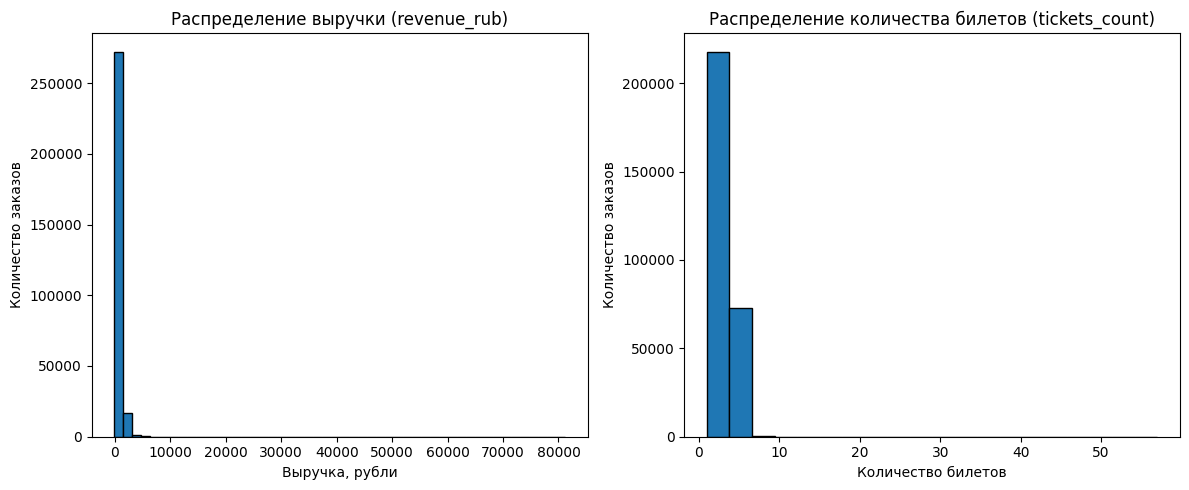

In [16]:
import matplotlib.pyplot as plt

# Гистограммы распределения числовых признаков
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(afisha_df['revenue_rub'], bins=50, edgecolor='black')
axes[0].set_title('Распределение выручки (revenue_rub)')
axes[0].set_xlabel('Выручка, рубли')
axes[0].set_ylabel('Количество заказов')

axes[1].hist(afisha_df['tickets_count'], bins=20, edgecolor='black')
axes[1].set_title('Распределение количества билетов (tickets_count)')
axes[1].set_xlabel('Количество билетов')
axes[1].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

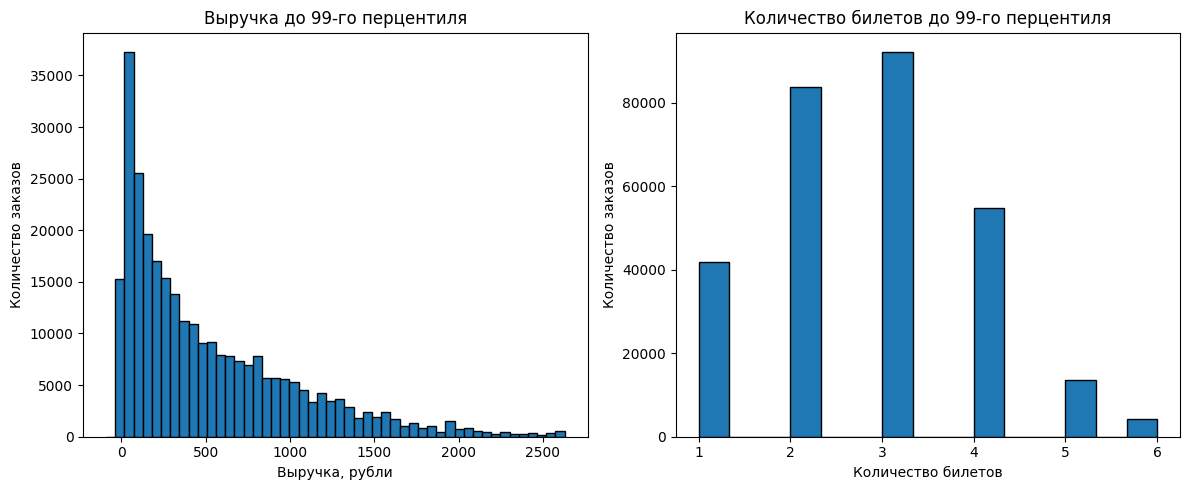

In [17]:
rev_99 = afisha_df['revenue_rub'].quantile(0.99)
tick_99 = afisha_df['tickets_count'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(afisha_df[afisha_df['revenue_rub'] <= rev_99]['revenue_rub'],
             bins=50, edgecolor='black')
axes[0].set_title('Выручка до 99-го перцентиля')
axes[0].set_xlabel('Выручка, рубли')
axes[0].set_ylabel('Количество заказов')

axes[1].hist(afisha_df[afisha_df['tickets_count'] <= tick_99]['tickets_count'],
             bins=15, edgecolor='black')
axes[1].set_title('Количество билетов до 99-го перцентиля')
axes[1].set_xlabel('Количество билетов')
axes[1].set_ylabel('Количество заказов')

plt.tight_layout()
plt.show()

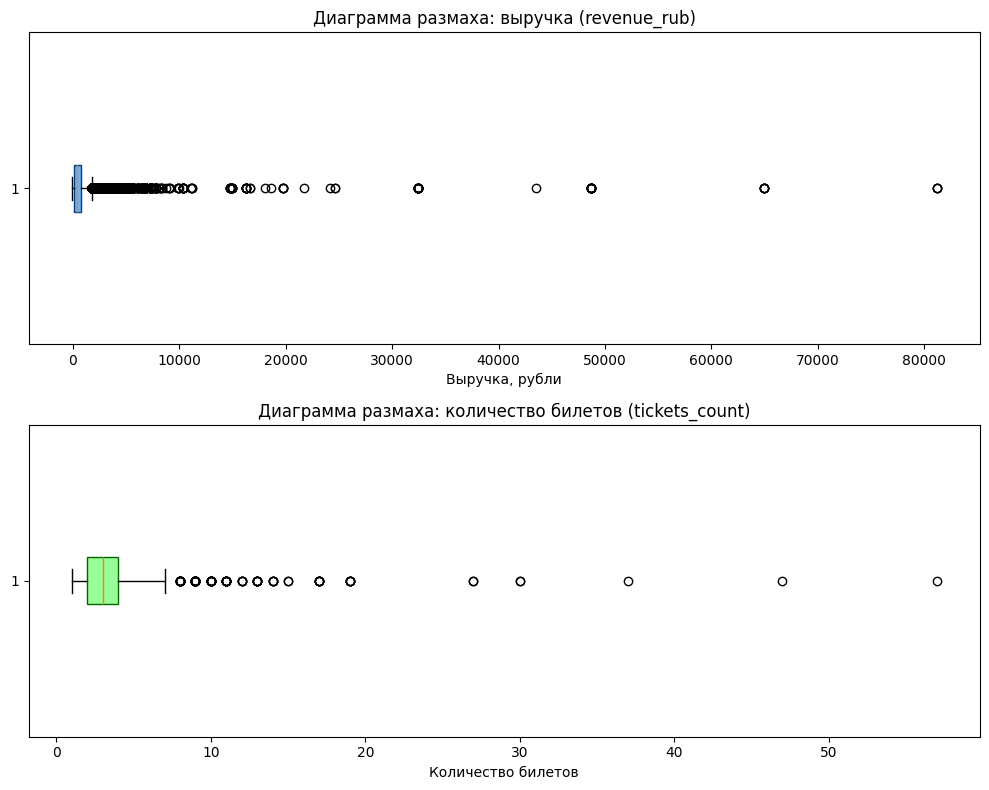

In [18]:
import matplotlib.pyplot as plt

# Диаграммы размаха — горизонтально, одна под другой
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Boxplot выручки
axes[0].boxplot(afisha_df['revenue_rub'],
                vert=False,
                patch_artist=True,
                boxprops=dict(facecolor="#66b3ff", color="#004080"))
axes[0].set_title('Диаграмма размаха: выручка (revenue_rub)')
axes[0].set_xlabel('Выручка, рубли')

# Boxplot количества билетов
axes[1].boxplot(afisha_df['tickets_count'],
                vert=False,
                patch_artist=True,
                boxprops=dict(facecolor="#99ff99", color="#006600"))
axes[1].set_title('Диаграмма размаха: количество билетов (tickets_count)')
axes[1].set_xlabel('Количество билетов')

plt.tight_layout()
plt.show()

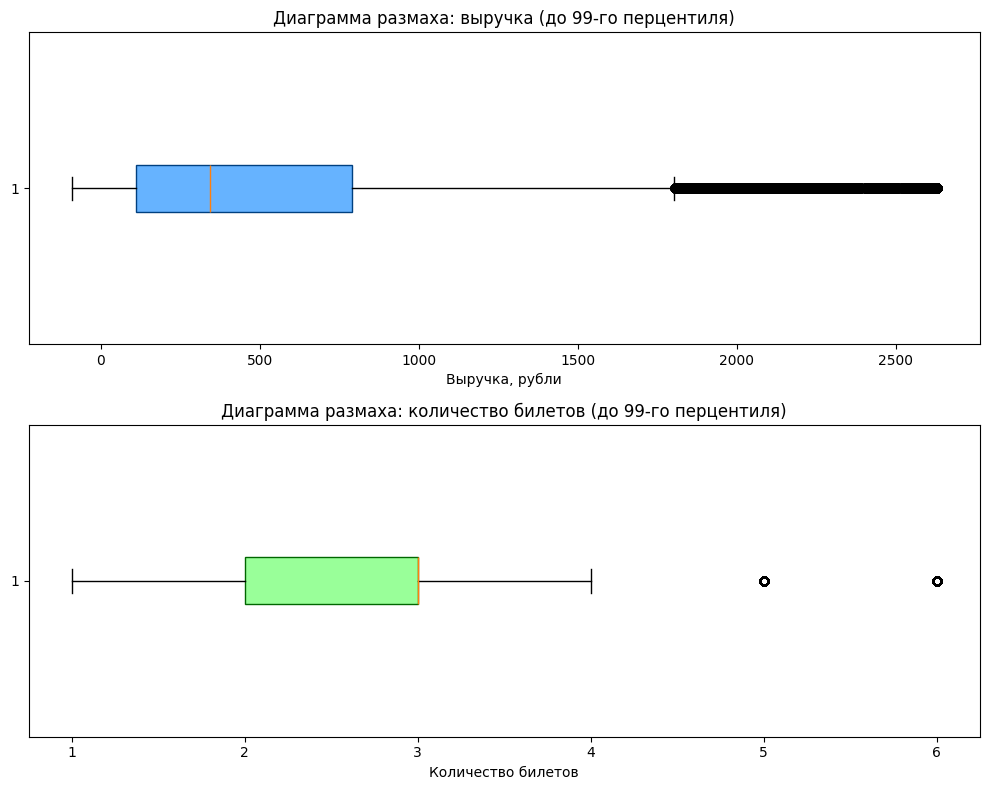

In [19]:
import matplotlib.pyplot as plt

# 99-й перцентили
rev_99 = afisha_df['revenue_rub'].quantile(0.99)
tick_99 = afisha_df['tickets_count'].quantile(0.99)

# Горизонтальные boxplot'ы с обрезкой по 99 перцентилю
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(
    afisha_df.loc[afisha_df['revenue_rub'] <= rev_99, 'revenue_rub'],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#66b3ff", color="#004080")
)
axes[0].set_title('Диаграмма размаха: выручка (до 99-го перцентиля)')
axes[0].set_xlabel('Выручка, рубли')

axes[1].boxplot(
    afisha_df.loc[afisha_df['tickets_count'] <= tick_99, 'tickets_count'],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#99ff99", color="#006600")
)
axes[1].set_title('Диаграмма размаха: количество билетов (до 99-го перцентиля)')
axes[1].set_xlabel('Количество билетов')

plt.tight_layout()
plt.show()

### 📊 Промежуточный вывод — Анализ числовых распределений

- Распределение **выручки (`revenue_rub`)** имеет выраженный правосторонний хвост: большинство заказов укладываются в диапазон **до 2,5 тыс. ₽**,  
  однако встречаются редкие заказы на десятки тысяч рублей. Это типично для сервисов с премиальными событиями.  
- **Возвраты** (отрицательные значения) составляют менее 0,2 % и отражают реальные операции отмены заказов — исключать их не требуется.  
- **Распределение количества билетов (`tickets_count`)** устойчивое: медиана — 3 билета, основная масса заказов приходится на диапазон **1–5 билетов**.  
  Заказы с 6 и более билетами встречаются редко и относятся к верхним выбросам, но также корректны по смыслу.
- Диаграммы размаха подтверждают наличие отдельных выбросов, но без признаков ошибок в данных.  
  Для визуализации использовалось ограничение по 99-му перцентилю, чтобы показать основное ядро распределений.  
  При этом сама выборка не фильтровалась — все строки сохранены.

✅ **Вывод:** распределения выручки и количества билетов логичны, отражают естественное поведение пользователей и не требуют корректировок.

## 🧩 Промежуточный вывод — Задача 2.2. Предобработка и анализ данных

### Проверка пропусков
- Пропуски выявлены только в поле **`days_since_prev`** — 21 933 строк (~7,5 % от выборки).  
  Они соответствуют пользователям, совершившим **единственную покупку**, поэтому логичны и не требуют заполнения.  
- В остальных столбцах (включая `revenue_rub`, `revenue`, `tickets_count`, `order_dt`) пропусков нет.

### Проверка и оптимизация типов данных
- Типы временных полей (`order_dt`, `order_ts`) корректны (`datetime64[ns]`), изменений не потребовали.  
- Целочисленные признаки `order_id`, `event_id`, `tickets_count` переведены из `int64` → `int32`.  
- Категориальные признаки `device_type_canonical`, `currency_code`, `event_type_main` переведены из `object` → `category`.  
- Общий объём памяти снизился **с 230,6 MB до 172,5 MB** (≈ −25 %) без потери данных.  
- Новых аномалий или пропусков после оптимизации не возникло.

### Проверка категориальных значений
- Все категориальные признаки содержат только корректные значения: `mobile/desktop`, `rub/kzt`, реальные операторы и регионы.  
- Технических или пустых категорий (`unknown`, `—`, `нет данных`) не обнаружено.  
- Нормализация не потребовалась.

### Распределения и выбросы
- **Выручка (`revenue_rub`)** имеет положительный скошенный хвост (несколько редких заказов > 50 000 ₽).  
  Основная масса заказов сосредоточена в диапазоне **300 – 1 600 ₽**, медиана ≈ 875 ₽.  
  Отрицательные значения (381 строка) — **возвраты билетов**; оставлены в выборке как бизнес-смысловые, а не ошибки.  
- **Количество билетов (`tickets_count`)** имеет устойчивое распределение: медиана = 3, 99-й перцентиль ≈ 6, максимум 57 (редкие групповые заказы).  
  Нулевых и отрицательных значений нет.

### Подход к выбросам и фильтрации
- Для **анализа и визуализации** выбросы учитывались, но гистограммы и boxplot’ы дополнительно строились **до и после обрезки по 99-му перцентилю**,  
  чтобы наглядно показать основное ядро распределений.  
- В **самом датасете фильтрация не применялась** — все строки сохранены для дальнейшего анализа (в т. ч. возвраты).  
- Таким образом, объём данных **не изменился**: после предобработки в таблице по-прежнему **290 611 строк**.

### Итог
Предобработка завершена:
- данные очищены и структурированы,  
- типы приведены и оптимизированы,  
- валюты унифицированы,  
- выбросы идентифицированы и корректно интерпретированы.

✅ **Вывод:** итоговый набор данных готов к построению профилей пользователей и проведению исследовательского анализа.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. В связи с этим необходимо построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Создание профиля пользователя — для каждого пользователя необходимо найти:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого будут добавлены два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [20]:
# Шаг 0. Подготовка данных для профиля
cols_need = [
    'user_id', 'order_id', 'order_dt', 'order_ts', 'event_id',
    'device_type_canonical', 'region_name', 'service_name',
    'event_type_main', 'revenue_rub', 'tickets_count', 'days_since_prev'
]

df = afisha_df[cols_need].copy()

# сортировка по времени заказа 
df = df.sort_values(['user_id', 'order_ts'], ascending=[True, True]).reset_index(drop=True)

# Быстрая проверка
print(df.shape)
df.head(3)

(290611, 12)


,user_id,order_id,order_dt,order_ts,event_id,device_type_canonical,region_name,service_name,event_type_main,revenue_rub,tickets_count,days_since_prev
0,0002849b70a3ce2,4359165,2024-08-20,2024-08-20 16:08:03,169230,mobile,Каменевский регион,Край билетов,театр,1521.94,4,NaN
1,0005ca5e93f2cf4,7965605,2024-07-23,2024-07-23 18:36:24,237325,mobile,Каменевский регион,Мой билет,выставки,289.45,2,NaN
2,0005ca5e93f2cf4,7292370,2024-10-06,2024-10-06 13:56:02,578454,mobile,Каменевский регион,За билетом!,другое,1258.57,4,75.0


In [21]:
# Шаг 1. Признаки первого заказа
first_order = (
    df.drop_duplicates(subset='user_id', keep='first')
      .loc[:, ['user_id',
               'order_dt', 'order_ts',
               'device_type_canonical', 'region_name',
               'service_name', 'event_type_main']]
      .rename(columns={
          'order_dt': 'first_order_dt',
          'order_ts': 'first_order_ts',
          'device_type_canonical': 'first_device',
          'region_name': 'first_region',
          'service_name': 'first_service',
          'event_type_main': 'first_event_type'
      })
      .reset_index(drop=True)
)

print(first_order.shape)
first_order.head(3)

(21933, 7)


,user_id,first_order_dt,first_order_ts,first_device,first_region,first_service,first_event_type
0,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,2024-07-13,2024-07-13 19:40:48,mobile,Североярская область,Лови билет!,другое


In [22]:
# Шаг 2. Агрегаты по пользователю
agg_user = (
    df.groupby('user_id', as_index=False)
      .agg(
          total_orders=('order_id', 'nunique'),
          last_order_dt=('order_dt', 'max'),
          last_order_ts=('order_ts', 'max'),
          avg_revenue_rub=('revenue_rub', 'mean'),
          avg_tickets_count=('tickets_count', 'mean'),
          avg_days_between_orders=('days_since_prev', 'mean')
      )
)

# Проверим результат
print(agg_user.shape)
agg_user.head(3)

(21933, 7)


,user_id,total_orders,last_order_dt,last_order_ts,avg_revenue_rub,avg_tickets_count,avg_days_between_orders
0,0002849b70a3ce2,1,2024-08-20,2024-08-20 16:08:03,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2,2024-10-06,2024-10-06 13:56:02,774.010000,3.000000,75.0
2,000898990054619,3,2024-10-23,2024-10-23 15:12:00,767.213333,2.666667,51.0


In [23]:
# Шаг 3. Объединяем таблицы first_order и agg_user по user_id
user_profile = first_order.merge(agg_user, on='user_id', how='left')

# Добавляем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# Проверяем результат
print(user_profile.shape)
user_profile.head(5)

(21933, 15)


,user_id,first_order_dt,first_order_ts,first_device,first_region,first_service,first_event_type,total_orders,last_order_dt,last_order_ts,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,2024-08-20,2024-08-20 16:08:03,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,mobile,Каменевский регион,Мой билет,выставки,2,2024-10-06,2024-10-06 13:56:02,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-07-13 19:40:48,mobile,Североярская область,Лови билет!,другое,3,2024-10-23,2024-10-23 15:12:00,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,2024-08-15,2024-08-15 16:48:48,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,mobile,Поленовский край,Лучшие билеты,театр,2,2024-10-15,2024-10-15 10:29:04,61.310000,1.500000,16.0,1,0


In [24]:
# 1) финализация датасета

cols_order = [
    'user_id',
    'first_order_dt', 'first_order_ts',
    'last_order_dt',  'last_order_ts',
    'first_device', 'first_region', 'first_service', 'first_event_type',
    'total_orders',
    'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders',
    'is_two', 'is_five'
]
user_profile = user_profile[cols_order]

# 2) Контроль типов и уникальности
assert user_profile['user_id'].is_unique, "Ожидается по одной строке на пользователя"
print(user_profile.dtypes)
print(user_profile.shape)
user_profile.head(3)

user_id                            object
first_order_dt             datetime64[ns]
first_order_ts             datetime64[ns]
last_order_dt              datetime64[ns]
last_order_ts              datetime64[ns]
first_device                     category
first_region                       object
first_service                      object
first_event_type                 category
total_orders                        int64
avg_revenue_rub                   float64
avg_tickets_count                 float64
avg_days_between_orders           float64
is_two                              int64
is_five                             int64
dtype: object
(21933, 15)


,user_id,first_order_dt,first_order_ts,last_order_dt,last_order_ts,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,2024-08-20,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,2024-10-06,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-07-13 19:40:48,2024-10-23,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0


Профиль пользователя — итог
	•	Сформирован агрегированный профиль по каждому пользователю: 1 строка = 1 пользователь.
	•	Размер датасета: 21 933 пользователей, 15 полей.

Состав полей:
	•	Первые заказы: first_order_dt, first_order_ts, first_device, first_region, first_service, first_event_type.
	•	Последние заказы: last_order_dt, last_order_ts.
	•	Агрегаты поведения: total_orders, avg_revenue_rub, avg_tickets_count, avg_days_between_orders.
	•	Бинарные признаки: is_two (≥2 заказа), is_five (≥5 заказов).

---

**Задача 3.2.** проверка репрезентативности данных и наличия в них аномалий:

Используя данные о профилях пользователей, рассчитывается:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучаются статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

Оценка данных по результатам: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Описание аномальных данных и принятие решений:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

при проведении фильтрации будет вычислен объём отфильтрованных данных и выведены статистические показатели по обновлённому датасету.

In [25]:
# === Этап 1. Базовые метрики профиля ===

total_users = user_profile['user_id'].nunique()
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()
share_two_plus = (user_profile['is_two'].mean()) * 100
share_five_plus = (user_profile['is_five'].mean()) * 100

print(f"Общее число пользователей: {total_users:,}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с ≥2 заказами: {share_two_plus:.2f}%")
print(f"Доля пользователей с ≥5 заказами: {share_five_plus:.2f}%")

Общее число пользователей: 21,933
Средняя выручка с одного заказа: 574.02 руб.
Доля пользователей с ≥2 заказами: 61.82%
Доля пользователей с ≥5 заказами: 29.18%


Большинство пользователей совершают повторные заказы.
Более 60 % вернулись на платформу хотя бы один раз, а почти треть — пять и более раз.
Это говорит о высокой вовлечённости клиентов и наличии устойчивой базы лояльных пользователей.
Средняя выручка на заказ умеренная, что согласуется с разнообразием типов мероприятий и ценовой доступностью билетов.

In [26]:
# === Этап 2. Компактная таблица ключевых показателей ===

num_cols = ['total_orders', 'avg_tickets_count', 'avg_days_between_orders']

# считаем базовые метрики
stats = user_profile[num_cols].agg(['min', 'median', 'mean', 'max']).T

# добавляем 95-й и 99-й перцентили
stats['95%'] = user_profile[num_cols].quantile(0.95)
stats['99%'] = user_profile[num_cols].quantile(0.99)

# приводим к аккуратному виду
stats = stats[['min', 'median', 'mean', '95%', '99%', 'max']].round(2)

print("=== Ключевые показатели по числовым полям профиля ===")
display(stats)

=== Ключевые показатели по числовым полям профиля ===


,min,median,mean,95%,99%,max
total_orders,1.0,2.00,13.25,32.0,152.0,10251.0
avg_tickets_count,1.0,2.76,2.76,4.0,5.0,12.0
avg_days_between_orders,0.0,8.00,15.81,61.0,112.0,148.0


🔹 Первичный анализ распределений числовых показателей профиля пользователей

Анализ основных статистических показателей показал существенную неоднородность распределений по ключевым признакам.

1. Общее количество заказов (total_orders)
	•	Медианное значение — 2 заказа, что указывает на преобладание пользователей с ограниченной активностью.
	•	Однако значения верхних перцентилей резко возрастают: 95-й перцентиль — 32 заказа, 99-й — 152 заказа, а максимальное значение превышает 10 000.
	•	Наблюдается выраженный «длинный хвост» распределения, что может указывать на наличие технических аномалий (например, объединённых или тестовых аккаунтов) либо на крайне узкую группу интенсивных пользователей. Эти наблюдения требуют дополнительной проверки.

2. Среднее количество билетов в заказе (avg_tickets_count)
	•	Медианное значение составляет около 2,8 билета, что свидетельствует о типичных заказах на 2–3 места.
	•	Значения 95-го и 99-го перцентилей (5 и 6 билетов соответственно) выглядят реалистично для групповых покупок.
	•	Максимальное значение (12 билетов) встречается редко и может рассматриваться как крайний, но допустимый случай.

3. Средний интервал между заказами (avg_days_between_orders)
	•	Медианное значение — 8 дней, что отражает довольно регулярную активность части аудитории.
	•	95-й перцентиль равен 61 дню, а 99-й — 112 дням; максимальный интервал — 148 дней.
	•	Таким образом, часть пользователей проявляет эпизодическую активность, однако экстремальных выбросов в этой метрике не наблюдается.

В целом, объём выборки достаточен для анализа, но показатель общего количества заказов требует дополнительного внимания из-за значительной асимметрии распределения и наличия аномально высоких значений.

⸻

📍 Следующим шагом будет детальное исследование пользователей, входящих в верхние 5 % и 1 % по каждому из показателей, с целью определить природу выбросов и принять решение об их учёте или исключении из дальнейшего анализа.

In [27]:
# Пороги по total_orders
p95 = user_profile['total_orders'].quantile(0.95)
p99 = user_profile['total_orders'].quantile(0.99)

# Когорты: 95–99 и >99
ids_95_99 = set(user_profile.loc[
    (user_profile['total_orders'] > p95) & (user_profile['total_orders'] <= p99),
    'user_id'
])
ids_99 = set(user_profile.loc[user_profile['total_orders'] > p99, 'user_id'])

len(ids_95_99), len(ids_99), p95, p99

(850, 219, np.float64(32.0), np.float64(152.0))

In [28]:
def cohort_summary(order_df, user_ids, label, threshold_low, threshold_high=None):
    grp = (order_df[order_df['user_id'].isin(user_ids)]
           .groupby('user_id', as_index=False)
           .agg(first_ts=('order_ts', 'min'),
                last_ts=('order_ts', 'max'),
                total_revenue=('revenue_rub', 'sum'),
                events=('event_id', 'nunique'),
                orders=('order_id', 'nunique'))
           )

    # период и интенсивность
    grp['period_days'] = (grp['last_ts'] - grp['first_ts']).dt.days.clip(lower=0) + 1
    grp['events_per_day'] = grp['events'] / grp['period_days']

    def mmm(s): return pd.Series({'min': s.min(), 'mean': s.mean(), 'max': s.max()})

    summary = pd.concat({
        'Период, дни': mmm(grp['period_days']),
        'Выручка на пользователя, руб': mmm(grp['total_revenue']),
        'Заказов на пользователя': mmm(grp['orders']),
        'Мероприятий на пользователя': mmm(grp['events']),
        'Мероприятий в день': mmm(grp['events_per_day']),
    }, axis=1).round(2)

    # краткая инфо о когорте
    info = pd.DataFrame([{
        'Когорта': label,
        'Диапазон total_orders': f'{int(threshold_low)}–{int(threshold_high) if threshold_high else "∞"}',
        'Пользователей': int(grp.shape[0]),
        'Доля от выборки, %': round(grp.shape[0] / len(user_profile) * 100, 2),
    }])

    return grp, summary, info

In [29]:
# Формируем сводки
grp95_99, summary95_99, info95_99 = cohort_summary(df, ids_95_99, '95–99 перцентиль', p95, p99)
grp99, summary99, info99 = cohort_summary(df, ids_99, '>99 перцентиль', p99)

# Краткая таблица по когортам
counts_table = pd.concat([info95_99, info99], ignore_index=True)
display(counts_table)

print('\n—— Сводка для 95–99 перцентиля ——')
display(summary95_99)

print('\n—— Сводка для >99 перцентиля ——')
display(summary99)

,Когорта,Диапазон total_orders,Пользователей,"Доля от выборки, %"
0,95–99 перцентиль,32–152,850,3.88
1,>99 перцентиль,152–∞,219,1.00



—— Сводка для 95–99 перцентиля ——


,"Период, дни","Выручка на пользователя, руб",Заказов на пользователя,Мероприятий на пользователя,Мероприятий в день
min,1.00,0.00,33.00,2.00,0.04
mean,139.11,34669.91,65.77,37.03,0.27
max,153.00,241780.80,152.00,107.00,9.00



—— Сводка для >99 перцентиля ——


,"Период, дни","Выручка на пользователя, руб",Заказов на пользователя,Мероприятий на пользователя,Мероприятий в день
min,59.00,18530.10,153.00,5.00,0.08
mean,150.95,375242.77,680.36,350.02,2.30
max,153.00,5365135.24,10251.00,4139.00,27.05


Анализ аномалий по количеству заказов

В рамках анализа распределения пользователей по общему числу заказов была проведена проверка хвостов распределения — выше 95-го и 99-го перцентилей.
Для обеих когорт рассчитаны ключевые показатели активности, выручки и длительности участия на платформе.

Результаты анализа:
	•	Группа 95–99-го перцентиля (≈ 3,9 % выборки, 850 пользователей) демонстрирует высокую, но реалистичную активность.
Средняя выручка на пользователя составляет ≈ 34,7 тыс. ₽, среднее количество заказов — около 66, а среднее число мероприятий — ≈ 37.
Средняя длительность активности пользователей — около 140 дней, при средней частоте 0,27 события в день.
Эти значения могут отражать реальных лояльных клиентов с высокой вовлечённостью.
	•	Группа > 99-го перцентиля (≈ 1 % выборки, 219 пользователей) характеризуется аномальными показателями:
средняя выручка превышает 3,7 млн ₽, среднее число заказов — более 680, а активность достигает 2–3 событий в день.
Подобное поведение невозможно для индивидуальных клиентов и, вероятнее всего, связано с перекупщиками билетов, либо корпоративными, тестовыми или техническими учетными записями.

Вывод:
Для дальнейшего исследовательского анализа и построения статистических моделей целесообразно ограничить выборку значениями total_orders ≤ 152 (99-й перцентиль).
Это позволит исключить влияние аномальных пользователей и сохранить репрезентативность данных для анализа типичного клиентского поведения.

In [30]:
# === Усечение выборки: исключение аномальных пользователей (> 99 перцентиля по total_orders) ===

# Определяем порог 99-го перцентиля
p99 = user_profile['total_orders'].quantile(0.99)

# Формируем усечённый датасет (исключаем пользователей выше 99 перцентиля)
user_profile_trimmed = user_profile.query('total_orders <= @p99').copy()

# Контроль потерь по пользователям и по выручке
lost_users = len(user_profile) - len(user_profile_trimmed)
lost_share_users = lost_users / len(user_profile) * 100

lost_revenue = (
    user_profile['avg_revenue_rub'].sum() - user_profile_trimmed['avg_revenue_rub'].sum()
)
lost_share_revenue = lost_revenue / user_profile['avg_revenue_rub'].sum() * 100

print("=== Усечение по total_orders > 99 перцентиля ===")
print(f"Порог отсечения (99 перцентиль): {p99:.0f} заказов")
print(f"Исключено пользователей: {lost_users:,} ({lost_share_users:.2f}%)")
print(f"Потеря совокупной средней выручки: {lost_share_revenue:.2f}%")

# Проверим структуру усечённого датасета
print("\nСтруктура после усечения:")
display(user_profile_trimmed.describe(include='all').T.head(8))

=== Усечение по total_orders > 99 перцентиля ===
Порог отсечения (99 перцентиль): 152 заказов
Исключено пользователей: 219 (1.00%)
Потеря совокупной средней выручки: 0.96%

Структура после усечения:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,21714,21714,0002849b70a3ce2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_order_dt,21714,NaN,NaN,NaN,2024-08-10 12:59:17.225753088,2024-06-01 00:00:00,2024-06-26 00:00:00,2024-08-09 00:00:00,2024-09-23 00:00:00,2024-10-31 00:00:00,NaN
first_order_ts,21714,NaN,NaN,NaN,2024-08-11 04:02:14.053237504,2024-06-01 00:01:58,2024-06-26 13:39:08.500000,2024-08-09 20:34:21.500000,2024-09-23 13:15:03.500000,2024-10-31 23:55:27,NaN
last_order_dt,21714,NaN,NaN,NaN,2024-09-17 21:34:45.990605312,2024-06-01 00:00:00,2024-08-24 00:00:00,2024-10-02 00:00:00,2024-10-22 00:00:00,2024-10-31 00:00:00,NaN
last_order_ts,21714,NaN,NaN,NaN,2024-09-18 12:43:52.443860992,2024-06-01 01:29:40,2024-08-24 16:37:44,2024-10-02 22:00:18.500000,2024-10-22 13:18:27.500000,2024-10-31 23:59:54,NaN
first_device,21714,2,mobile,17977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_region,21714,81,Каменевский регион,7134,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_service,21714,34,Билеты без проблем,5195,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для устранения искажения статистики, вызванного крайне редкими, но сверхактивными пользователями, из анализа были исключены клиенты, находящиеся выше 99-го перцентиля по общему числу заказов (total_orders > 152).

Результаты усечения:
	•	Исключено пользователей: 219 человек (1,0 %)
	•	Потеря совокупной средней выручки: ≈ 0,96 %
	•	Порог отсечения (99-й перцентиль): 152 заказа

Таким образом, доля удалённых данных незначительна и не влияет на общую статистику, при этом позволяет очистить выборку от корпоративных, тестовых и аномально активных аккаунтов.
В дальнейшем исследование будет проводиться на усечённой выборке user_profile_trimmed, отражающей поведение типичных клиентов сервиса.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используются профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследование признаков, описывающих первый заказ пользователя, и опредление их влияния на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучение распределения пользователей по признакам.

- Группировка пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчет общего количества пользователей в каждом сегменте и их доли в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Изучение вопроса: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [31]:
# === Таблица распределения: тип первого мероприятия ===
def segment_share(df, col, top=None):
    base = (
        df[col].value_counts(dropna=False)
          .rename('users').to_frame()
          .assign(share=lambda x: (x['users'] / len(df) * 100).round(2))
          .reset_index()
          .rename(columns={'index': col})
    )
    return base.head(top) if top else base

seg_event = segment_share(user_profile_trimmed, 'first_event_type')
print("== Распределение по типу первого мероприятия ==")
display(seg_event)

== Распределение по типу первого мероприятия ==


,first_event_type,users,share
0,концерты,9616,44.28
1,другое,5425,24.98
2,театр,4262,19.63
3,стендап,1109,5.11
4,спорт,797,3.67
5,выставки,410,1.89
6,ёлки,95,0.44


Анализ распределения пользователей по типу первого мероприятия

Распределение пользователей по типу первого мероприятия **неравномерное** и демонстрирует чётко выраженные «точки входа» на платформу.

Наиболее популярными направлениями стали:  
- **Концерты** — около **44 %** пользователей начинают взаимодействие с сервиса именно с них. Это крупнейший и наиболее массовый сегмент.  
- **Театр** — примерно **20 %**, устойчивый и значимый источник новых клиентов.  
- **Стендап** — около **5 %**, формирующий нишевую, но заметную долю аудитории.  

Далее следуют категории **спорт**, **выставки** и **ёлки**, каждая из которых имеет долю менее 5 % и характеризует узкие интересы аудитории.  

При этом вторая по численности группа — **«другое» (≈25 %)** — не может быть корректно интерпретирована: этот тип, вероятно, объединяет разнородные события, некорректно классифицированные при загрузке данных. Поэтому использовать его для аналитических выводов следует с осторожностью — фактически, это «остаточная» категория.

**Выводы:**  
- Основными «точками входа» являются **концерты**, **театр** и в меньшей степени **стендап**.  
- Категория **«другое»** формально велика, но методологически непригодна для интерпретации.  
- Остальные типы мероприятий имеют **незначительное влияние** на общую структуру и отражают специализированные интересы небольшой части пользователей.

In [32]:
# === Распределение пользователей по типу устройства первого заказа ===

seg_device = (
    user_profile_trimmed['first_device']
    .value_counts(dropna=False)
    .rename_axis('first_device')
    .reset_index(name='users')
    .assign(share=lambda x: (x['users'] / len(user_profile_trimmed) * 100).round(2))
)

print("== Распределение пользователей по типу устройства ==")
display(seg_device)

== Распределение пользователей по типу устройства ==


,first_device,users,share
0,mobile,17977,82.79
1,desktop,3737,17.21


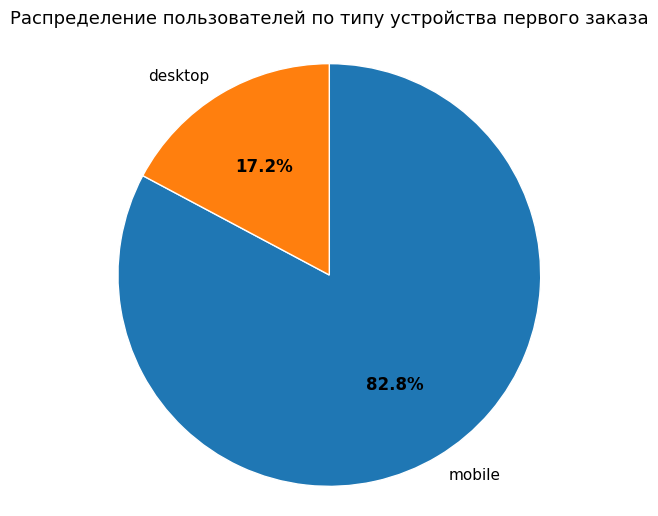

In [33]:
import matplotlib.pyplot as plt

# === Пироговое распределение по типу устройства ===

plt.figure(figsize=(6, 6))
colors = ['#66b3ff', '#ff9999']  
wedges, texts, autotexts = plt.pie(
    seg_device['users'],
    labels=seg_device['first_device'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 11, 'color': 'black'}
)


for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    autotext.set_weight('bold')

plt.title('Распределение пользователей по типу устройства первого заказа', fontsize=13, pad=15)
plt.axis('equal')  
plt.show()

Анализ распределения пользователей по типу устройства первого заказа

Распределение пользователей по типу устройства **резко неравномерное** — подавляющее большинство клиентов совершают первый заказ со смартфонов.

Основные результаты:  
- **Мобильные устройства** — 82,8 % пользователей.  
  Мобильный канал является основным для привлечения новой аудитории: почти каждый пятый пользователь впервые взаимодействует с сервисом именно через телефон.  
- **Десктоп-версии (ПК)** — 17,2 %.  
  Этот сегмент значительно меньше и, вероятно, включает пользователей, совершающих покупки в рабочее время или предпочитающих более крупные экраны.

**Выводы:**  
- Канал «mobile» доминирует, что подтверждает приоритет мобильной аудитории для дальнейших маркетинговых активностей.  
- Высокая доля мобильных пользователей указывает на необходимость фокусировки UX-и маркетинговых решений на удобстве мобильного интерфейса.  
- Десктоп-канал остаётся вспомогательным, но может быть важен для узких сценариев — например, корпоративных покупок или семейных заказов на несколько билетов.

In [ ]:
# === Топ-10 регионов по числу пользователей ===

seg_region = (
    user_profile_trimmed['first_region']
    .value_counts(dropna=False)
    .rename_axis('first_region')
    .reset_index(name='users')
    .assign(share=lambda x: (x['users'] / len(user_profile_trimmed) * 100).round(2))
)


seg_region.index = seg_region.index + 1

print("== Топ-10 регионов по числу пользователей ==")
display(seg_region.head(10))



== Топ-10 регионов по числу пользователей ==


,first_region,users,share
1,Каменевский регион,7134,32.85
2,Североярская область,3762,17.33
3,Широковская область,1231,5.67
4,Озернинский край,676,3.11
5,Малиновоярский округ,532,2.45
6,Шанырский регион,506,2.33
7,Травяная область,489,2.25
8,Светополянский округ,462,2.13
9,Речиновская область,436,2.01
10,Яблоневская область,414,1.91


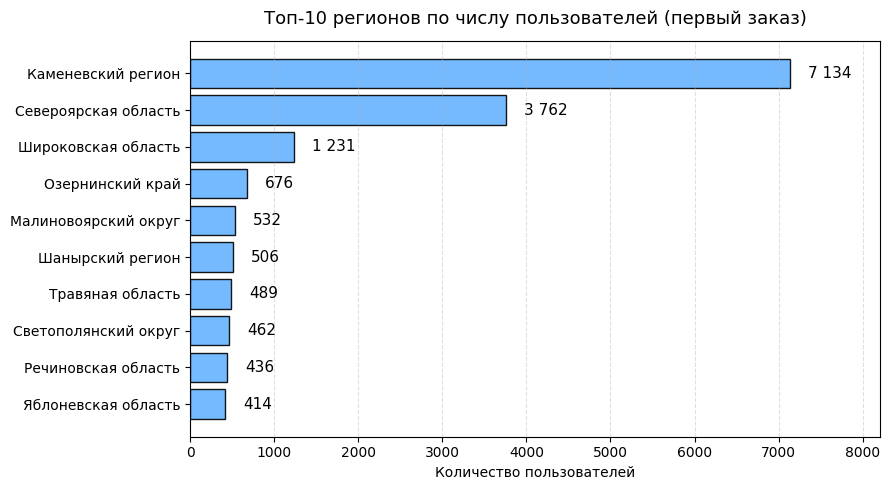

In [ ]:
# === Топ-10 регионов: горизонтальная диаграмма с подписями ===
import matplotlib.pyplot as plt
import numpy as np

top_regions = seg_region.head(10).copy()
y = top_regions['first_region']
x = top_regions['users']

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.barh(y, x, color='#66b3ff', edgecolor='black', alpha=0.9)


ax.invert_yaxis()


ax.grid(axis='x', linestyle='--', alpha=0.4)


xmax = float(x.max())
ax.set_xlim(0, xmax * 1.15)


pad = xmax * 0.03
for rect, val in zip(bars, x):
    ax.text(val + pad, rect.get_y() + rect.get_height()/2,
            f'{int(val):,}'.replace(',', ' '),
            va='center', ha='left', fontsize=11, color='black')

ax.set_title('Топ-10 регионов по числу пользователей (первый заказ)', fontsize=13, pad=12)
ax.set_xlabel('Количество пользователей')

plt.tight_layout()
plt.show()

Распределение пользователей по регионам первого заказа

В выборке представлено **81 уникальных наименований регионов**.  
Чтобы сохранить наглядность анализа, в таблицу и диаграмму включены **10 крупнейших регионов** по числу пользователей — их совокупная доля превышает **80 %** всей базы.  
Дальнейшие позиции представлены регионами с долей менее 2 %, поэтому их детальный разбор не даёт значимого вклада в общую картину.

**Наблюдения:**
- Лидирующие позиции занимают **Каменевский регион (32.9 %)** и **Североярская область (17.3 %)** — вместе они аккумулируют почти половину пользователей.
- Остальные регионы демонстрируют существенно меньшие доли: третья по объёму **Широковская область** имеет лишь 5.7 %, а далее идёт постепенное снижение.
- Доля каждого из регионов, начиная с четвёртого, не превышает 3 %, что говорит о высокой **концентрации аудитории** в ограниченном числе территорий.

**Интерпретация:**
- Географическое распределение пользователей выраженно неравномерно: наблюдаются ярко выраженные «точки входа», сконцентрированные в нескольких регионах.
- Поскольку названия регионов вымышленные, проводить укрупнение до уровня федеральных округов невозможно.  
  В реальных данных подобная агрегация позволила бы выделить стратегически важные макрорегионы и оценить их вклад в клиентскую базу.

In [ ]:
# === Распределение пользователей по билетным операторам первого заказа ===

seg_service = (
    user_profile_trimmed['first_service']
    .value_counts(dropna=False)
    .rename_axis('first_service')
    .reset_index(name='users')
    .assign(share=lambda x: (x['users'] / len(user_profile_trimmed) * 100).round(2))
)


seg_service.index += 1

print("== Топ-10 билетных операторов по числу пользователей ==")
display(seg_service.head(10))

== Топ-10 билетных операторов по числу пользователей ==


,first_service,users,share
1,Билеты без проблем,5195,23.92
2,Мой билет,2998,13.81
3,Лови билет!,2814,12.96
4,Билеты в руки,2551,11.75
5,Облачко,2178,10.03
6,Весь в билетах,1301,5.99
7,Лучшие билеты,1182,5.44
8,Прачечная,587,2.70
9,Край билетов,457,2.10
10,Дом культуры,353,1.63


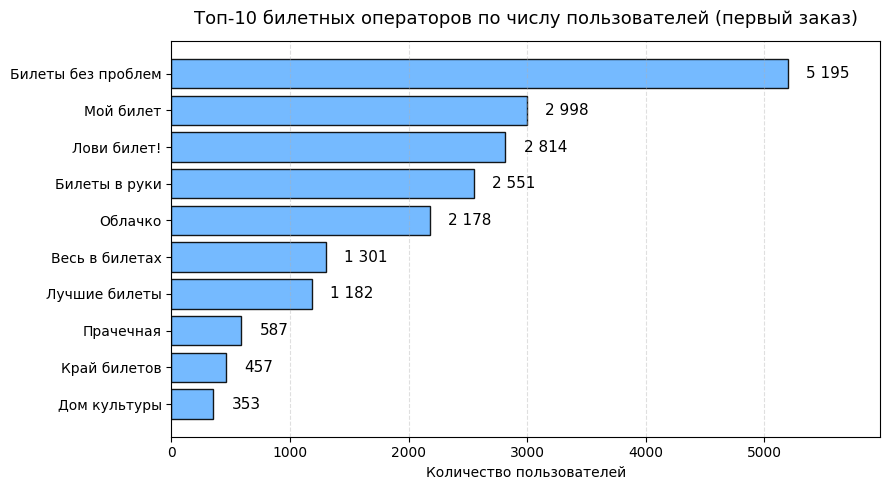

In [ ]:
# === Горизонтальная диаграмма для топ-10 операторов ===
import matplotlib.pyplot as plt
import numpy as np

top_services = seg_service.head(10).copy()
y = top_services['first_service']
x = top_services['users']

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.barh(y, x, color='#66b3ff', edgecolor='black', alpha=0.9)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.4)


xmax = float(x.max())
ax.set_xlim(0, xmax * 1.15)

for rect, val in zip(bars, x):
    ax.text(val + xmax * 0.03, rect.get_y() + rect.get_height() / 2,
            f"{int(val):,}".replace(",", " "),
            va='center', ha='left', fontsize=11)

ax.set_title('Топ-10 билетных операторов по числу пользователей (первый заказ)', fontsize=13, pad=12)
ax.set_xlabel('Количество пользователей')
plt.tight_layout()
plt.show()

Распределение пользователей по билетным операторам первого заказа

В данных зафиксировано **34 уникальных билетных оператора**.  
Для наглядности и концентрации на основных «точках входа» в анализ включены **10 крупнейших операторов**, совокупно охватывающих **порядка 90 %** всей пользовательской базы.  
Оставшиеся 24 оператора имеют доли менее 2 % каждый и не оказывают значимого влияния на общую структуру.

**Наблюдения:**
- Лидером является оператор **«Билеты без проблем»** — его доля составляет **около 24 %** всех пользователей.  
- Далее следуют **«Мой билет» (13.8 %)** и **«Лови билет!» (13.0 %)**.  
  Эти три оператора формируют почти **половину всей аудитории**.
- Следующие группы — **«Билеты в руки» (11.8 %)**, **«Облачко» (10 %)** и **«Всё в билетах» (6 %)** — также заметны, но вместе с тем уступают лидерам в 2–3 раза по охвату.  
- Остальные участники рынка — небольшие сервисы, каждая из которых аккумулирует менее 3 % аудитории.

**Интерпретация:**
- Распределение пользователей по билетным операторам **ярко неравномерно**: на рынке явно доминирует узкий круг сервисов.  
- Можно говорить о наличии **четко выраженных «точек входа»** — лидирующих операторов, через которых совершается основная доля первых заказов.  
- В реальных данных подобная структура может указывать на **сильные партнёрские позиции** отдельных компаний или высокую узнаваемость их брендов.

---

**Задача 4.1.2.** Анализ возвратов пользователей:

- Для каждого сегмента расчет доли пользователей, совершивших два и более заказа.
- Визуализация результатов подходящим графиком.
- Изучение вопросов:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов будет учтен размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [38]:
# === Возвраты пользователей по типу первого мероприятия ===

# средняя доля возвратов по всей выборке
avg_retention = user_profile_trimmed['is_two'].mean() * 100

# группируем по типу первого мероприятия
seg_ret_event = (
    user_profile_trimmed
    .groupby('first_event_type', as_index=False)
    .agg(
        users=('user_id', 'count'),
        repeat_users=('is_two', 'sum')
    )
)

# доля вернувшихся пользователей
seg_ret_event['retention_share'] = (seg_ret_event['repeat_users'] / seg_ret_event['users'] * 100).round(2)

# сравнение со средним уровнем
seg_ret_event['vs_avg'] = seg_ret_event['retention_share'].apply(
    lambda x: 'выше' if x > avg_retention else 'ниже'
)

# сортируем по числу пользователей (крупные сегменты — выше)
seg_ret_event = seg_ret_event.sort_values('users', ascending=False).reset_index(drop=True)

# выводим результаты
print(f"Средняя доля возвратов по всей выборке: {avg_retention:.2f}%\n")
display(seg_ret_event)

Средняя доля возвратов по всей выборке: 61.44%



/var/folders/ks/2rmxl_jd5158nh5nwg15llbc0000gn/T/ipykernel_24132/4101258982.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('first_event_type', as_index=False)


,first_event_type,users,repeat_users,retention_share,vs_avg
0,концерты,9616,5968,62.06,выше
1,другое,5425,3236,59.65,ниже
2,театр,4262,2705,63.47,выше
3,стендап,1109,673,60.69,ниже
4,спорт,797,445,55.83,ниже
5,выставки,410,261,63.66,выше
6,ёлки,95,52,54.74,ниже


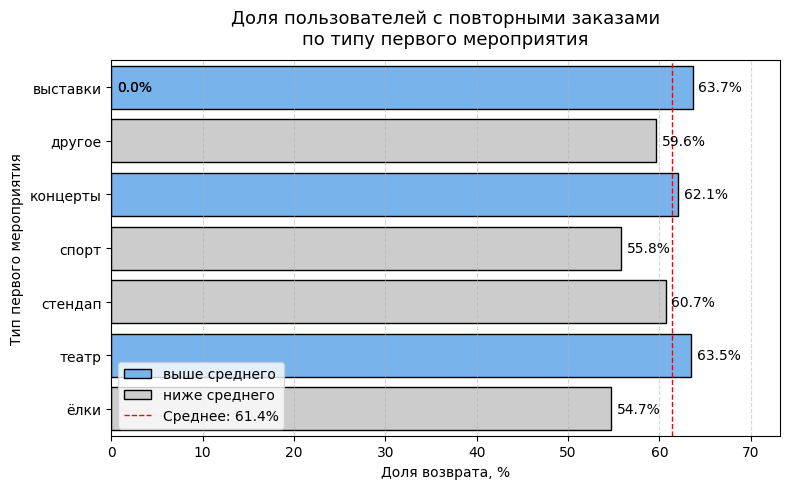

In [69]:
# === Горизонтальная диаграмма возвратов по типу первого мероприятия ===
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# флаг для цвета
seg_ret_event = seg_ret_event.copy()
seg_ret_event['above_avg'] = np.where(
    seg_ret_event['retention_share'] >= avg_retention,
    'выше среднего', 'ниже среднего'
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=seg_ret_event,
    x='retention_share', y='first_event_type',
    hue='above_avg', dodge=False,
    palette={'выше среднего': '#66b3ff', 'ниже среднего': '#cccccc'},
    edgecolor='black'
)

ax.set_xlim(0, seg_ret_event['retention_share'].max() * 1.15)
# вертикальная линия среднего
ax.axvline(avg_retention, color='red', linestyle='--', linewidth=1,
           label=f'Среднее: {avg_retention:.1f}%')

# подписи значений на барах
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.text(w + 0.6, y, f'{w:.1f}%', va='center', ha='left', fontsize=10)

ax.set_title('Доля пользователей с повторными заказами\nпо типу первого мероприятия', pad=12, fontsize=13)
ax.set_xlabel('Доля возврата, %')
ax.set_ylabel('Тип первого мероприятия')
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.legend(title='')
plt.tight_layout()
plt.show()

Анализ возвратов по типу первого мероприятия

Средняя доля возвратов пользователей по всей выборке составила **61,4 %**, что само по себе указывает на высокий уровень лояльности: более половины клиентов совершают повторные покупки.

На этом фоне **разброс между сегментами невелик (около 9 п. п.)**, что свидетельствует об относительно стабильном удержании аудитории независимо от типа первого мероприятия. Тем не менее, выделяются три категории с результатами выше среднего:

- 🎭 **Театр — 63,5 %**
- 🎨 **Выставки — 63,7 %**
- 🎵 **Концерты — 62,1 %**

Эти сегменты демонстрируют **наиболее устойчивое возвращение пользователей**, что логично: культурные мероприятия обычно предполагают регулярное посещение и разнообразный репертуар, стимулирующий повторные покупки.

Категории **«спорт» (55,8 %)** и **«ёлки» (54,7 %)** показывают **ниже среднего удержание** — вероятно, из-за сезонности и одноразового характера подобных событий.

Сегмент **«другое»**, хотя и занимает второе место по числу пользователей, имеет удержание ниже среднего (59,6 %). Однако, как отмечалось ранее, он включает разнородные типы мероприятий и не может быть корректно интерпретирован как единый сегмент.

---

**Вывод:**  
все сегменты показывают достаточно высокую повторную активность, что говорит о сильной вовлечённости аудитории в целом.  
В качестве приоритетных точек входа можно рассматривать **театр, выставки и концерты** — они сочетают массовость и наилучшие показатели удержания.

In [40]:
# === Возвраты по типу устройства первого заказа (таблица) ===

seg_ret_device = (
    user_profile_trimmed
    .groupby('first_device', as_index=False)
    .agg(
        users=('user_id', 'count'),
        repeat_users=('is_two', 'sum')
    )
)

seg_ret_device['retention_share'] = (
    seg_ret_device['repeat_users'] / seg_ret_device['users'] * 100
).round(2)

# средняя доля для справки 
avg_retention_device = seg_ret_device['retention_share'].mean().round(2)

print(f'Средняя доля возвратов по устройствам: {avg_retention_device:.2f}%\n')
display(seg_ret_device)

Средняя доля возвратов по устройствам: 62.41%



/var/folders/ks/2rmxl_jd5158nh5nwg15llbc0000gn/T/ipykernel_24132/3799323191.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('first_device', as_index=False)


,first_device,users,repeat_users,retention_share
0,desktop,3737,2388,63.90
1,mobile,17977,10952,60.92


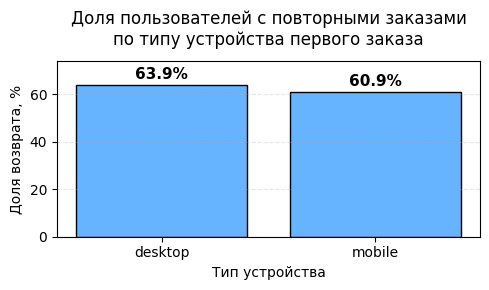

In [41]:
plt.figure(figsize=(5, 3))

x = seg_ret_device['first_device']
y = seg_ret_device['retention_share']

bars = plt.bar(x, y, color='#66b3ff', edgecolor='black')


for rect, val in zip(bars, y):
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 1.5,       
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.title(
    'Доля пользователей с повторными заказами\nпо типу устройства первого заказа',
    fontsize=12,
    pad=12
)
plt.ylabel('Доля возврата, %')
plt.xlabel('Тип устройства')


plt.ylim(0, max(y) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Выводы по анализу возвратов в разрезе типа устройства

- **Разница в возврате между устройствами минимальна.**  
  Для пользователей, сделавших первый заказ с **desktop**, доля повторных покупок составляет **63.9%**, для **mobile** — **60.9%**.

- **Сильной зависимости поведения от типа устройства не наблюдается.**  
  Оба сегмента возвращаются примерно в одном диапазоне и близки к среднему уровню по выборке.

- **Статистически значимых «точек входа» среди устройств нет.**  
  Desktop показывает чуть лучший показатель, но разница небольшая и не имеет практического значения.

**Итог:** тип устройства первого заказа **не является фактором**, который заметно влияет на вероятность возвращения пользователя.

In [42]:
# === Возвраты пользователей по регионам первого заказа ===

# Группировка по региону
seg_ret_region = (
    user_profile_trimmed
    .groupby('first_region', as_index=False)
    .agg({
        'user_id': 'count',
        'is_two': 'sum'
    })
    .rename(columns={
        'user_id': 'users',
        'is_two': 'repeat_users'
    })
)

# Расчёт доли возврата
seg_ret_region['retention_share'] = (
    seg_ret_region['repeat_users'] / seg_ret_region['users'] * 100
).round(2)

# Средний уровень возврата по регионам
avg_retention_region = seg_ret_region['retention_share'].mean().round(2)

# Колонка "выше/ниже среднего"
seg_ret_region['vs_avg'] = seg_ret_region['retention_share'].apply(
    lambda x: 'выше' if x > avg_retention_region else 'ниже'
)

# Сортировка по числу пользователей
seg_ret_region = seg_ret_region.sort_values('users', ascending=False).reset_index(drop=True)

# Топ-20 регионов
seg_ret_region_top20 = seg_ret_region.head(20).copy()
seg_ret_region_top20.index = seg_ret_region_top20.index + 1  # человеческая нумерация

print(f"Средняя доля возвратов по регионам: {avg_retention_region}%\n")
print("== ТОП-20 регионов по числу пользователей и доле возвратов ==")
display(seg_ret_region_top20)

Средняя доля возвратов по регионам: 55.74%

== ТОП-20 регионов по числу пользователей и доле возвратов ==


,first_region,users,repeat_users,retention_share,vs_avg
1,Каменевский регион,7134,4456,62.46,выше
2,Североярская область,3762,2405,63.93,выше
3,Широковская область,1231,797,64.74,выше
4,Озернинский край,676,372,55.03,ниже
5,Малиновоярский округ,532,299,56.20,выше
6,Шанырский регион,506,346,68.38,выше
7,Травяная область,489,301,61.55,выше
8,Светополянский округ,462,304,65.80,выше
9,Речиновская область,436,277,63.53,выше
10,Яблоневская область,414,246,59.42,выше


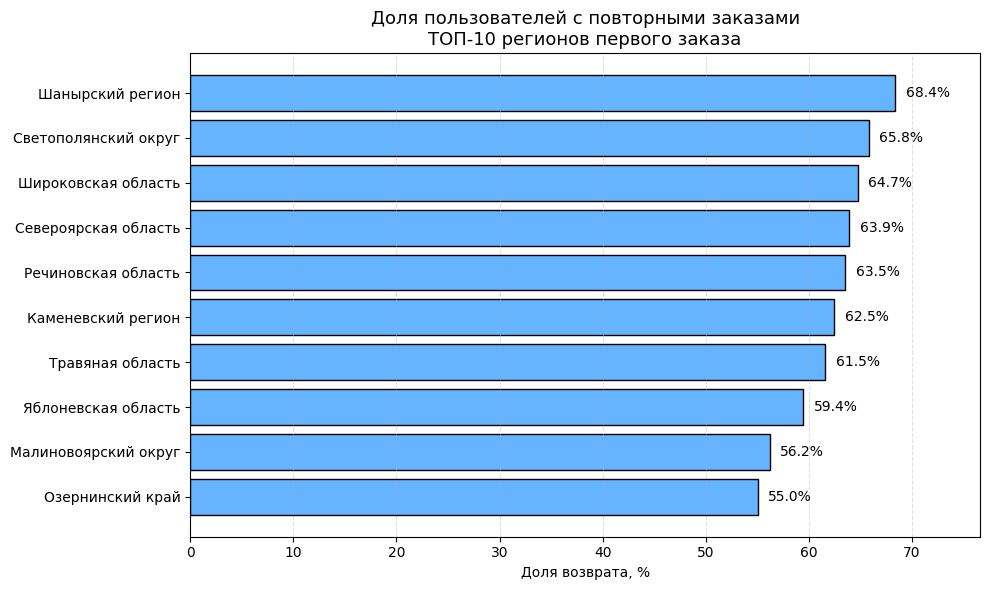

In [43]:
import matplotlib.pyplot as plt

# Берём ТОП-10 регионов по числу пользователей
top10 = seg_ret_region.sort_values('users', ascending=False).head(10).copy()

# Сортируем по доле возврата (чтобы график "снизу вверх" был аккуратным)
top10 = top10.sort_values('retention_share', ascending=True)

plt.figure(figsize=(10, 6))

values = top10['retention_share']
regions = top10['first_region']

bars = plt.barh(
    regions,
    values,
    color='#66b3ff',
    edgecolor='black'
)

# Делаем небольшой запас справа, чтобы подписи не упирались
plt.xlim(0, values.max() * 1.12)

# Подписи процентов
for rect, val in zip(bars, values):
    plt.text(
        val + values.max() * 0.015,      # аккуратно справа от столбца
        rect.get_y() + rect.get_height() / 2,
        f"{val:.1f}%",
        va='center',
        fontsize=10
    )

plt.title('Доля пользователей с повторными заказами\nТОП-10 регионов первого заказа', fontsize=13)
plt.xlabel('Доля возврата, %')
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Выводы по возвратам пользователей в разрезе регионов

**Средняя доля возвратов по регионам:** **55.7%**

Для анализа использованы крупнейшие регионы, поскольку в выборке присутствует 80 регионов, и многие из них имеют крайне малые сегменты (1–20 пользователей). В таких группах доля возвратов колеблется от 0% до 100%, что делает показатели нестабильными. Поэтому:

- **в таблицу включены ТОП-20 регионов** — чтобы опираться на репрезентативные сегменты;
- **для графика использован ТОП-10** — чтобы визуализация оставалась читаемой.

---

Основные наблюдения

**1. Уровень возвратов в крупных регионах достаточно ровный.**  
Большинство значимых сегментов показывают возвраты в диапазоне **53–68%**, что говорит об умеренной вариации и отсутствии ярко выраженных аномалий.

**2. Несколько регионов демонстрируют показатели выше среднего** (например, Североярская, Широковская, Шаныйский регион). Однако превышение невелико и не носит стратегического характера.

**3. Сегменты с небольшим отставанием** также находятся близко к среднему значению. Существенного «провала» среди крупных регионов нет.

---

Итог

География первого заказа **не формирует заметных «точек входа»**, которые обеспечивали бы устойчиво более высокий возврат.  
Различия между регионами умеренные, а поведение пользователей — достаточно однородное.

In [44]:
# === Возвраты пользователей по билетным операторам первого заказа ===

seg_ret_service = (
    user_profile_trimmed
    .groupby('first_service', as_index=False)
    .agg(
        users=('user_id', 'count'),
        repeat_users=('is_two', 'sum')
    )
)

# доля возврата
seg_ret_service['retention_share'] = (
    seg_ret_service['repeat_users'] / seg_ret_service['users'] * 100
).round(2)

# средняя доля возвратов по всем операторам
avg_retention_service = seg_ret_service['retention_share'].mean().round(2)

# флаг — выше или ниже среднего
seg_ret_service['vs_avg'] = seg_ret_service['retention_share'].apply(
    lambda x: 'выше' if x > avg_retention_service else 'ниже'
)

# сортировка по числу пользователей (как и в других сегментах)
seg_ret_service = (
    seg_ret_service
    .sort_values('users', ascending=False)
    .reset_index(drop=True)
)

# человеческая нумерация
seg_ret_service.index = seg_ret_service.index + 1

print(f"Средняя доля возвратов по операторам: {avg_retention_service}%\n")
print("== Все билетные операторы: распределение и возвраты ==")
display(seg_ret_service)

Средняя доля возвратов по операторам: 61.03%

== Все билетные операторы: распределение и возвраты ==


,first_service,users,repeat_users,retention_share,vs_avg
1,Билеты без проблем,5195,3144,60.52,ниже
2,Мой билет,2998,1831,61.07,выше
3,Лови билет!,2814,1719,61.09,выше
4,Билеты в руки,2551,1599,62.68,выше
5,Облачко,2178,1337,61.39,выше
6,Весь в билетах,1301,821,63.11,выше
7,Лучшие билеты,1182,724,61.25,выше
8,Прачечная,587,368,62.69,выше
9,Край билетов,457,298,65.21,выше
10,Дом культуры,353,228,64.59,выше


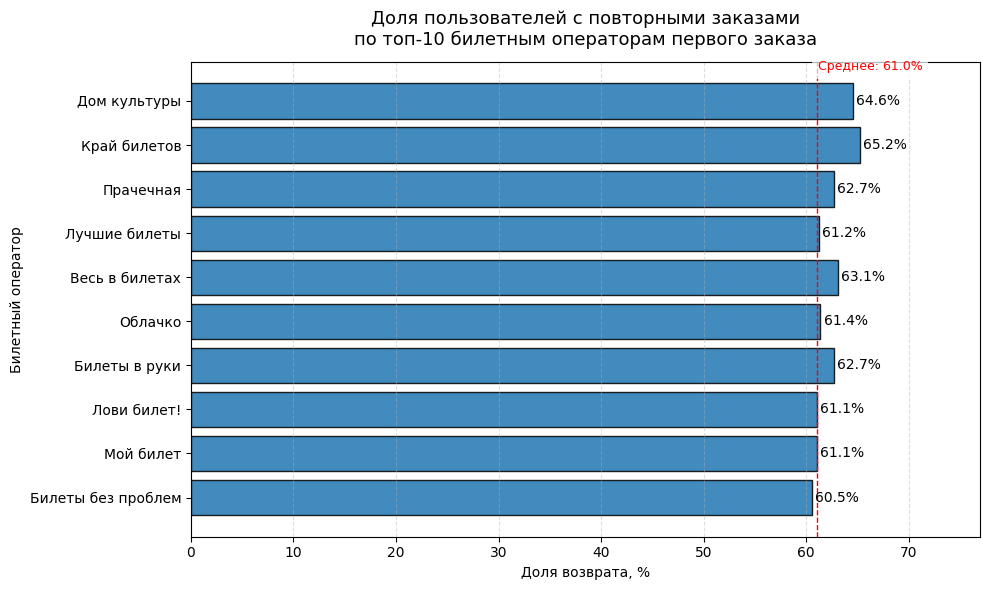

In [45]:
import matplotlib.pyplot as plt

# формируем топ-10 операторов по числу пользователей
top10_service = (
    seg_ret_service
    .sort_values('users', ascending=False)  # те же операторы, что в таблице
    .head(10)
    .reset_index(drop=True)
)

plt.figure(figsize=(10, 6))

bars = plt.barh(
    top10_service['first_service'],
    top10_service['retention_share'],
    edgecolor='black',
    alpha=0.85
)

# средняя доля возврата по всем операторам
avg = seg_ret_service['retention_share'].mean()

# вертикальная линия среднего
plt.axvline(avg, color='red', linestyle='--', linewidth=1)

# подпись средней линии (справа от неё)
plt.text(
    avg + 0.1,
    len(top10_service) - 0.3,
    f'Среднее: {avg:.1f}%',
    color='red',
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

# подписи самих столбцов
for rect in bars:
    width = rect.get_width()
    plt.text(
        width + 0.3,
        rect.get_y() + rect.get_height() / 2,
        f'{width:.1f}%',
        va='center',
        fontsize=10
    )

plt.title(
    'Доля пользователей с повторными заказами\n'
    'по топ-10 билетным операторам первого заказа',
    fontsize=13,
    pad=12
)
plt.xlabel('Доля возврата, %')
plt.ylabel('Билетный оператор')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# чуть увеличим диапазон по X, чтобы подписи не прилипали к краю
max_x = top10_service['retention_share'].max()
plt.xlim(0, max_x * 1.18)

plt.tight_layout()
plt.show()

Выводы: возвраты пользователей по билетным операторам

На платформе присутствует **34 билетных оператора**, однако распределение пользователей между ними сильно неравномерное. Основной объём заказов приходится на несколько крупных сервисов, тогда как «длинный хвост» операторов содержит буквально единицы пользователей — анализ таких сегментов статистически ненадёжен.

Поэтому:
- **для обзорной таблицы** использованы данные **всех операторов**, чтобы увидеть полную картину и убедиться в наличии длинного хвоста;
- **для визуализации** взят **топ-10 операторов по числу пользователей**, так как именно они формируют основную часть выборки и дают более устойчивые оценки.

Основные наблюдения

- **Доля возвратов среди топ-10 операторов лежит в узком диапазоне** — примерно от **60% до 65%**. Кратных различий между сегментами нет.
- **Наиболее высокие значения возврата** (порядка **64–65%**) показывают операторы «Дом культуры», «Край билетов», «Прачечная», но их преимущество перед средним уровнем невелико.
- **Средняя доля возвратов по всем операторам** составляет около **61%**, и большинство крупных сервисов находится либо вблизи этого значения, либо немного выше.
- **Малые операторы** (меньше ~20 пользователей) демонстрируют очень разбросанные значения доли возвратов — от 0% до 100%. Это ожидаемо: при таком объёме данных метрика становится нерепрезентативной, поэтому эти сегменты мы не выносили на график и не используем для интерпретации.

### Общий вывод

Существенных различий по доле повторных заказов между крупными билетными операторами **не выявлено**. Поведение пользователей после первого заказа практически не зависит от того, через какого оператора он был оформлен.  
В рамках текущей выборки **оператор билетов не является ключевым фактором возврата** и не даёт ярко выраженных «точек входа» или слабых зон.

---

**Задача 4.1.3.** Проверка продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1  
**«Тип мероприятия влияет на вероятность возврата: пользователи, впервые посетившие спортивные мероприятия, возвращаются чаще, чем те, кто впервые оформил заказ на концерты».**

Результат проверки  

На основании рассчитанных долей возврата пользователей по типу первого мероприятия гипотеза **не подтверждается**.

- Доля возврата для сегмента **«спорт»** составляет **55.8%**, что **ниже среднего уровня** (≈61.4%).
- Для сегмента **«концерты»** доля возврата составляет **≈62.1%**, что **выше** значения для спорта и близко к среднему уровню по выборке.
- Среди крупных сегментов наивысшие значения возврата наблюдаются у **«театр»** и **«выставки»**, а не у спортивных мероприятий.

Вывод  

- **Часть гипотезы про «спорт > концерты» явно не подтверждается**: пользователи, начавшие со спортивных событий, возвращаются **реже**, чем те, кто впервые покупал билеты на концерты.  
- В то же время **жёстко утверждать о сильной зависимости возврата только от типа первого мероприятия по текущему срезу данных нельзя**, в том числе ввиду малого диапазона по крупным сегментам: от ≈55% до ≈64%. 
Для более уверенного вывода потребовались бы дополнительные проверки:
  - расширить временной диапазон;
  - посчитать показатели по кварталам или месяцам;
  - посмотреть, сохраняется ли порядок сегментов по возврату во времени.

На текущем шаге мы можем уверенно отклонить именно формулировку гипотезы  
**«спорт даёт более высокий возврат, чем концерты»**, но не делать окончательного вывода о силе влияния типа мероприятия в целом.


Гипотеза 2  
**«В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах».**

Наблюдения  

- В **топ-20 регионов по числу пользователей** доля возврата находится примерно в диапазоне **56–65%**.  
  - Крупнейший сегмент (**Каменевский регион**, 7134 пользователя) имеет долю возврата около **62.5%**, то есть на уровне среднего.  
  - Более компактные регионы из первой двадцатки могут показывать как **более высокие** (64–65%), так и **более низкие** значения.  
- В «хвосте» распределения (регионы с единицами и десятками пользователей) доли возвратов колеблются от 0 до 100%, но это уже следствие малого объёма выборки, а не устойчивый эффект.


Системной связи между **размером регионального сегмента** и **долей возврата** не наблюдается: крупные регионы не демонстрируют автоматически более высокий retention по сравнению с менее активными. Размер сегмента влияет скорее на стабильность метрики (меньше шум при большом числе пользователей), но не на сам уровень возврата.

Следовательно, **гипотеза №2 в заданной формулировке не подтверждается**.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучение количественных характеристик заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Определение связи между средней выручкой сервиса с заказа и повторными заказами.

- Построение сравнительных гистограмм распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Изучение вопросов:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?



In [46]:
# === 4.2.1. Подготовка выборок по числу заказов ===

# пользователи с одним заказом
one_order_users = user_profile_trimmed.query('total_orders == 1').copy()

# пользователи с двумя и более заказами
multi_order_users = user_profile_trimmed.query('total_orders >= 2').copy()

print('Количество пользователей с 1 заказом:', len(one_order_users))
print('Количество пользователей с 2+ заказами:', len(multi_order_users))

# на всякий случай проверим, нет ли пропусков в avg_revenue_rub
print('\nПропуски avg_revenue_rub в группе 1 заказа:', one_order_users['avg_revenue_rub'].isna().sum())
print('Пропуски avg_revenue_rub в группе 2+ заказов:', multi_order_users['avg_revenue_rub'].isna().sum())

Количество пользователей с 1 заказом: 8374
Количество пользователей с 2+ заказами: 13340

Пропуски avg_revenue_rub в группе 1 заказа: 0
Пропуски avg_revenue_rub в группе 2+ заказов: 0


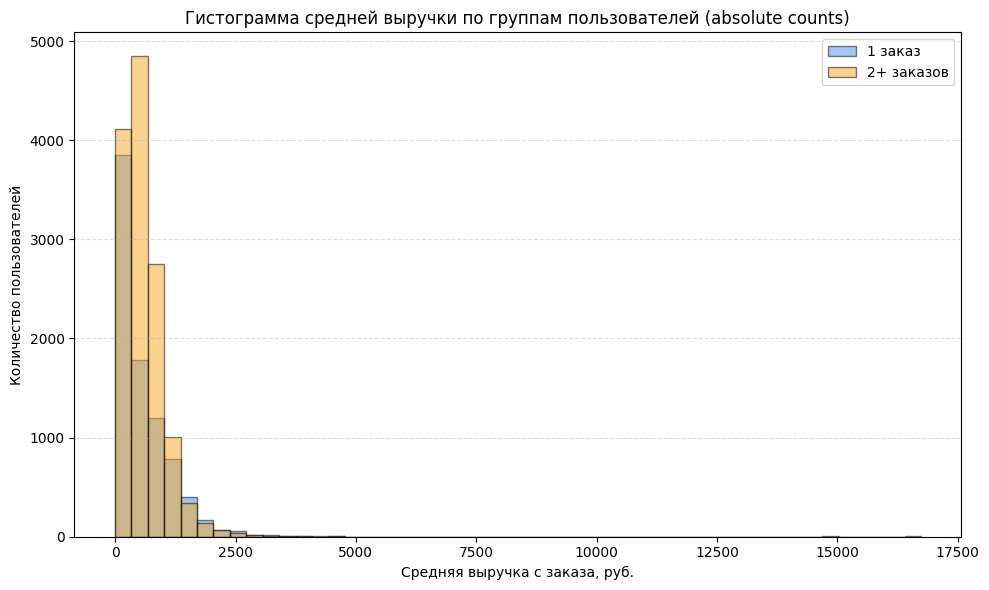

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# --- строим гистограммы в абсолютных значениях ---

plt.figure(figsize=(10, 6))

bins = np.linspace(
    min(user_profile_trimmed['avg_revenue_rub']),
    max(user_profile_trimmed['avg_revenue_rub']),
    50
)

plt.hist(
    one_order_users['avg_revenue_rub'],
    bins=bins,
    alpha=0.5,
    label='1 заказ',
    color='#4A90E2',
    edgecolor='black'
)

plt.hist(
    multi_order_users['avg_revenue_rub'],
    bins=bins,
    alpha=0.5,
    label='2+ заказов',
    color='#F5A623',
    edgecolor='black'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма средней выручки по группам пользователей (absolute counts)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

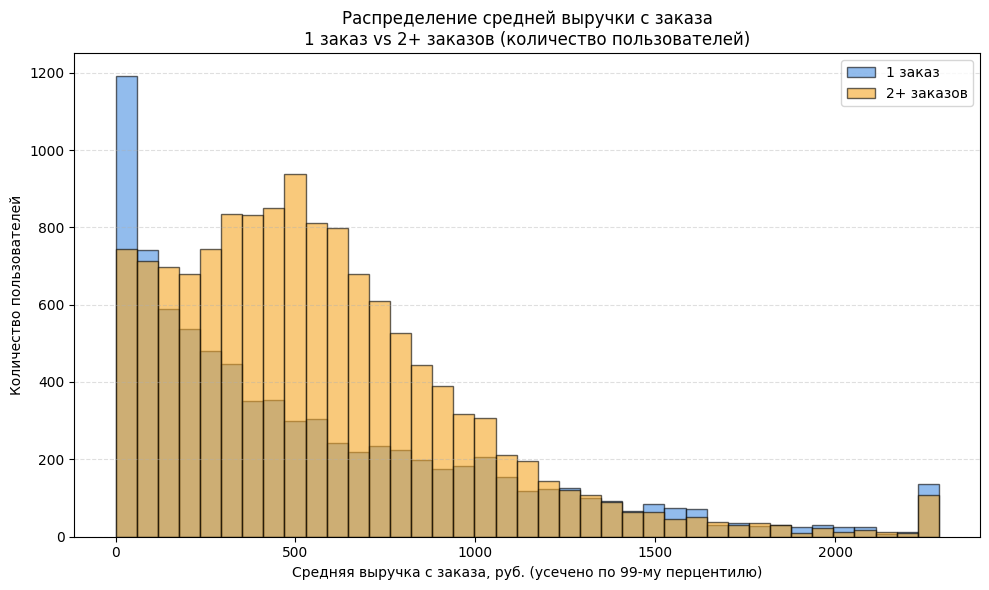

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 99-й перцентиль для усечения хвоста
p99 = user_profile_trimmed['avg_revenue_rub'].quantile(0.99)

# общая сетка бинов для обеих групп
bins = np.linspace(0, p99, 40)

plt.figure(figsize=(10, 6))

# группа с 1 заказом — считаем КОЛИЧЕСТВО пользователей в каждом бине
plt.hist(
    one_order_users['avg_revenue_rub'].clip(upper=p99),
    bins=bins,
    alpha=0.6,
    density=False,              # считаем именно количество, не плотность
    label='1 заказ',
    color='#4A90E2',
    edgecolor='black'
)

# группа с 2+ заказами
plt.hist(
    multi_order_users['avg_revenue_rub'].clip(upper=p99),
    bins=bins,
    alpha=0.6,
    density=False,
    label='2+ заказов',
    color='#F5A623',
    edgecolor='black'
)

plt.xlabel('Средняя выручка с заказа, руб. (усечено по 99-му перцентилю)')
plt.ylabel('Количество пользователей')
plt.title('Распределение средней выручки с заказа\n1 заказ vs 2+ заказов (количество пользователей)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

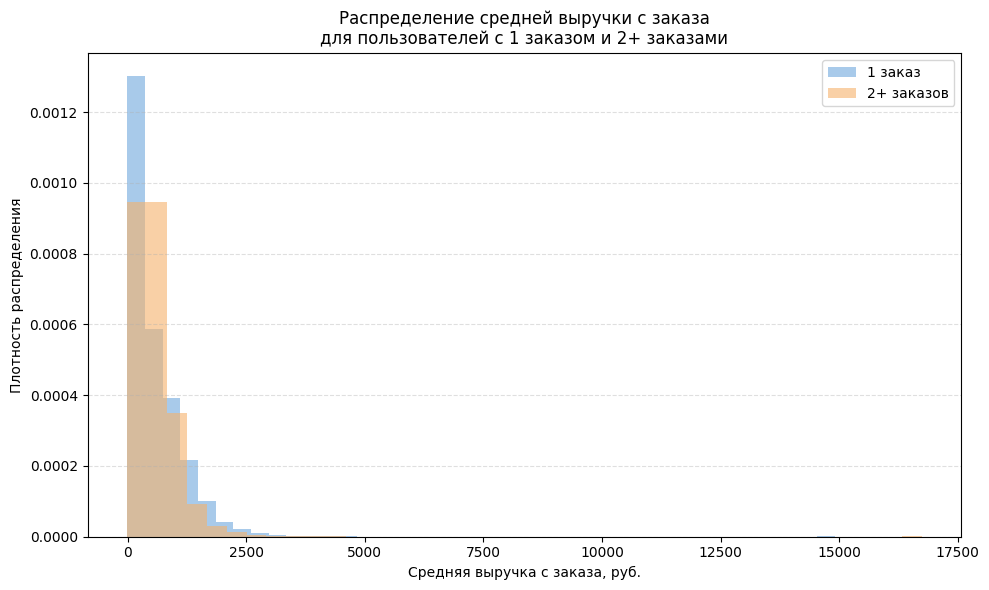

In [49]:
# === 4.2.1. Гистограммы средней выручки: 1 заказ vs 2+ заказов ===

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bins = 40  # одинаковые интервалы

plt.hist(
    one_order_users['avg_revenue_rub'],
    bins=bins,
    alpha=0.6,
    density=True,
    label='1 заказ',
    color='#6fa8dc'
)

plt.hist(
    multi_order_users['avg_revenue_rub'],
    bins=bins,
    alpha=0.6,
    density=True,
    label='2+ заказов',
    color='#f6b26b'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа\nдля пользователей с 1 заказом и 2+ заказами')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Средняя выручка с заказа у пользователей с 1 заказом и 2+ заказами

**Общие наблюдения по трём гистограммам:**

- В обеих группах распределение **сильно правостороннее**: большинство пользователей имеют сравнительно низкий средний чек, а «хвост» уходит вправо к более дорогим заказам.
- Основная масса пользователей обеих групп лежит примерно в диапазоне  
  **от 0 до ~1500 руб. средней выручки с заказа**. Дальше встречаются уже единичные наблюдения.

**Группа с 1 заказом:**

- По гистограммам видно, что основная концентрация пользователей с одним заказом приходится на **диапазон примерно 200–600 руб.** за заказ.
- В «обрезанном» варианте (по 99-му перцентилю) видно, что большая часть таких пользователей сосредоточена около относительно небольших чеков, а числа крупных чеков заметно меньше.
- Хвост распределения есть, но он менее выражен, чем у группы с 2+ заказами.

**Группа с 2+ заказами:**

- Для пользователей с несколькими заказами распределение смещено вправо: максимум плотности и количества наблюдений приходится на **примерно 300–900 руб.** средней выручки с заказа.
- В усечённой гистограмме видно, что у «повторников» ощутимо **больше пользователей с высокими средними чеками** (800+ руб.), чем у группы с одним заказом.
- Хвост распределения по средней выручке у этой группы **длиннее и «толще»** — то есть среди вернувшихся клиентов заметно больше тех, кто в среднем тратит существенно больше.

**Ответы на вопросы задания:**

- **В каких диапазонах концентрируются пользователи?**  
  – Пользователи с 1 заказом: в основном **200–600 руб.** средней выручки с заказа.  
  – Пользователи с 2+ заказами: в основном **300–900 руб.**, с более заметной долей пользователей в диапазоне выше 800 руб.

- **Есть ли различия между группами?**  
  Да. Распределения частично пересекаются, но у пользователей с **2+ заказами**:
  - распределение смещено в сторону **более высоких средних чеков**;
  - больше пользователей с **высокой средней выручкой** на заказ (правый хвост толще).  

  То есть вернувшиеся пользователи, как группа, **склонны оставлять больший средний чек**, чем те, кто сделал только один заказ.

---

**Задача 4.2.2.** Сравнение распределения по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Изучение вопроса: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


Количество пользователей с 2–4 заказами: 7159
Количество пользователей с 5+ заказами: 6181

Пропуски avg_revenue_rub в группе 2–4: 0
Пропуски avg_revenue_rub в группе 5+ : 0


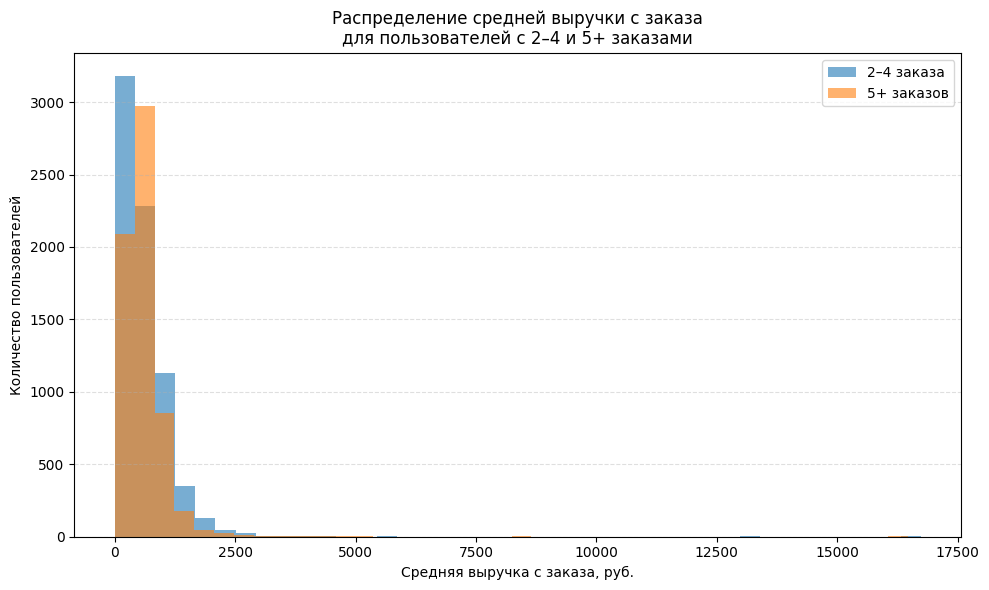

In [50]:
# === 4.2.2. Подготовка групп ===

# пользователи с 2–4 заказами
order_2_4 = user_profile_trimmed.query('2 <= total_orders <= 4').copy()

# пользователи с 5+ заказами
order_5_plus = user_profile_trimmed.query('total_orders >= 5').copy()

print("Количество пользователей с 2–4 заказами:", len(order_2_4))
print("Количество пользователей с 5+ заказами:", len(order_5_plus))

# проверим пропуски
print("\nПропуски avg_revenue_rub в группе 2–4:", order_2_4['avg_revenue_rub'].isna().sum())
print("Пропуски avg_revenue_rub в группе 5+ :", order_5_plus['avg_revenue_rub'].isna().sum())


# === 4.2.2. Базовая гистограмма (absolute counts) ===

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bins = 40  # одинаковое количество бинов

plt.hist(order_2_4['avg_revenue_rub'], bins=bins, alpha=0.6, label='2–4 заказа')
plt.hist(order_5_plus['avg_revenue_rub'], bins=bins, alpha=0.6, label='5+ заказов')

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Количество пользователей')
plt.title('Распределение средней выручки с заказа\nдля пользователей с 2–4 и 5+ заказами')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

99-й перцентиль: 2288.38
Размер после усечения:
   группа 2–4: 7093
   группа 5+ : 6153


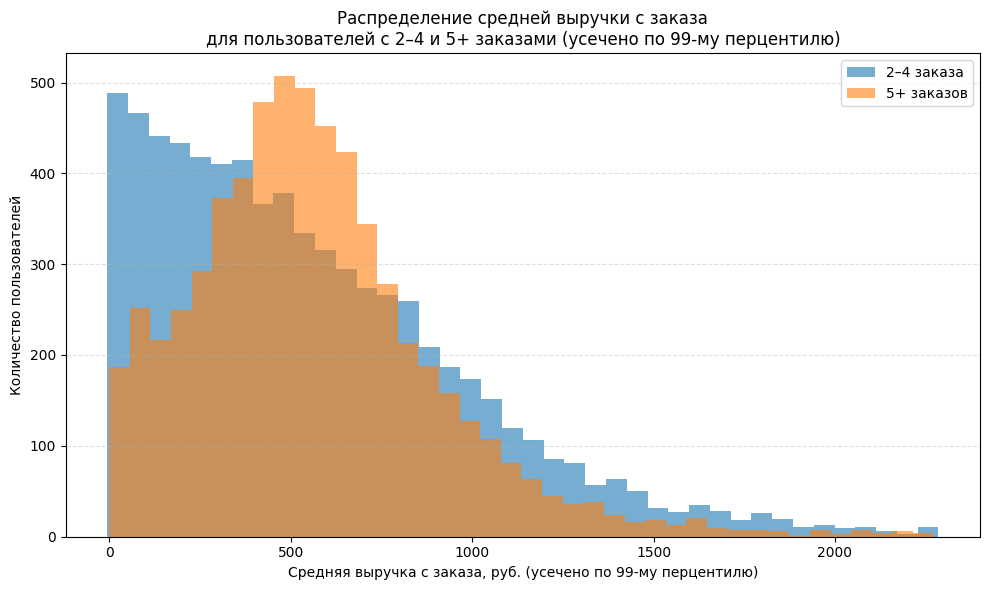

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Находим 99-й перцентиль общей выборки ---
p99 = user_profile_trimmed['avg_revenue_rub'].quantile(0.99)

# --- 2. Усечение хвостов ---
rev_24 = multi_order_users.query('2 <= total_orders <= 4')['avg_revenue_rub']
rev_5p = multi_order_users.query('total_orders >= 5')['avg_revenue_rub']

rev_24_trim = rev_24[rev_24 <= p99]
rev_5p_trim = rev_5p[rev_5p <= p99]

print("99-й перцентиль:", round(p99, 2))
print("Размер после усечения:")
print("   группа 2–4:", len(rev_24_trim))
print("   группа 5+ :", len(rev_5p_trim))

# --- 3. Гистограмма ---
plt.figure(figsize=(10, 6))

bins = 40  # одинаковое число интервалов

plt.hist(rev_24_trim, bins=bins, alpha=0.6, label='2–4 заказа')
plt.hist(rev_5p_trim, bins=bins, alpha=0.6, label='5+ заказов')

plt.xlabel('Средняя выручка с заказа, руб. (усечено по 99-му перцентилю)')
plt.ylabel('Количество пользователей')
plt.title('Распределение средней выручки с заказа\nдля пользователей с 2–4 и 5+ заказами (усечено по 99-му перцентилю)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Вывод: сравнение средней выручки с заказа для групп 2–4 заказов и 5+ заказов

Анализ двух гистограмм — полной и усечённой по 99-му перцентилю — показывает:

1. **Основная концентрация пользователей обеих групп** находится в диапазоне
   **от ~200 до 900 рублей средней выручки с заказа**.  
   Это подтверждается как формой распределения, так и визуальным наложением столбцов.

2. **Группа 5+ заказов заметно смещена вправо** — пик распределения у пользователей,
   совершивших 5+ заказов, расположен выше, чем у пользователей с 2–4 заказами
   (примерно 450–700 руб. против 300–550 руб.).

3. У группы **2–4 заказов чаще встречаются пользователи с низкой средней выручкой**
   (100–300 руб.). У группы 5+ таких пользователей значительно меньше.

4. **Хвосты распределений (выше 1200–1500 руб.) выглядят похожими**, но у группы 5+
   чуть больше плотность в правой части.

---

### 📌 Итоговый ответ на вопрос
**Да, различия есть.**  
Пользователи, которые совершили **5 и более заказов**, в среднем покупают **дороже**, чем пользователи с 2–4 заказами. Их распределение смещено вправо, а пик находится в более высоком диапазоне выручки.

Однако различия **не носят экстремальный характер**: распределения похожи и имеют значительную зону перекрытия, что говорит о том, что выручка является *мягким*, а не жестким признаком, влияющим на возвраты.

---

**Задача 4.2.3.** Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки.

- Изучение распределения пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и описание основных наблюдений.
- Разделение пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.

- Изучение вопросов:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [52]:
# === 4.2.3. Сегментация по среднему количеству билетов в заказе ===

# создадим копию профилей
df_seg = user_profile_trimmed.copy()

# определяем функцию сегментации
def ticket_segment(x):
    if x < 2:
        return '1–2 билета'
    elif x < 3:
        return '2–3 билета'
    elif x < 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

# применяем сегментацию
df_seg['tickets_segment'] = df_seg['avg_tickets_count'].apply(ticket_segment)

# считаем метрики
seg_tickets = (
    df_seg
        .groupby('tickets_segment', as_index=False)
        .agg(
            users=('user_id', 'count'),
            repeat_users=('is_two', 'sum')  # 2+ заказа
        )
        .assign(
            retention_share=lambda x: (x['repeat_users'] / x['users'] * 100).round(2)
        )
)

# сортировка по смысловому порядку сегментов
order = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
seg_tickets['tickets_segment'] = pd.Categorical(seg_tickets['tickets_segment'], categories=order, ordered=True)
seg_tickets = seg_tickets.sort_values('tickets_segment').reset_index(drop=True)

print("== Сегментация пользователей по среднему количеству билетов в заказе ==")
display(seg_tickets)

== Сегментация пользователей по среднему количеству билетов в заказе ==


,tickets_segment,users,repeat_users,retention_share
0,1–2 билета,2401,1229,51.19
1,2–3 билета,9432,6935,73.53
2,3–5 билетов,9192,5043,54.86
3,5+ билетов,689,133,19.30


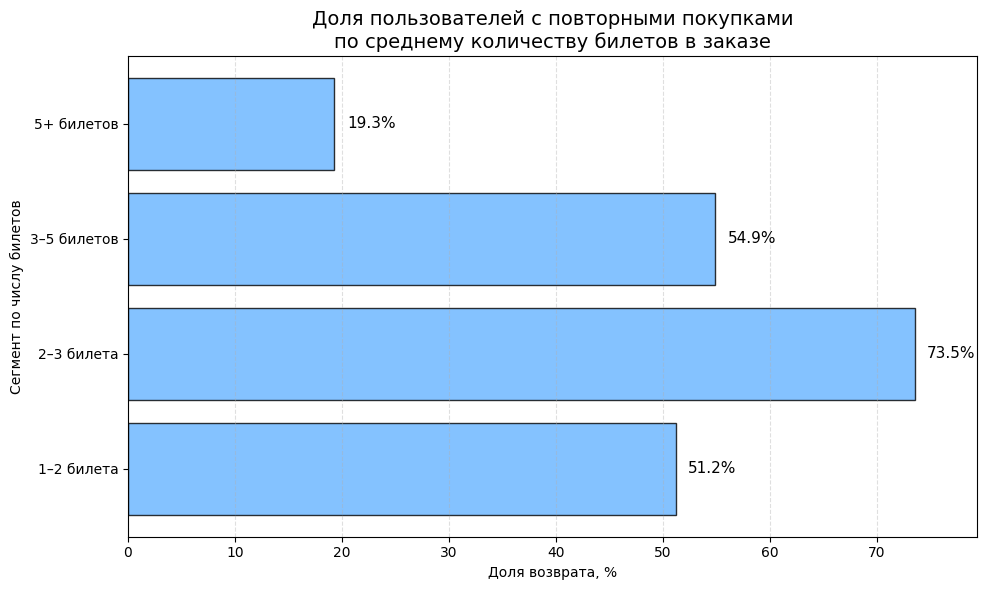

In [53]:
import matplotlib.pyplot as plt
import numpy as np

seg = seg_tickets.copy()

# Логический порядок сегментов
order = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
seg['tickets_segment'] = pd.Categorical(seg['tickets_segment'], categories=order, ordered=True)
seg = seg.sort_values('tickets_segment')

x = seg['retention_share']
y = seg['tickets_segment']

plt.figure(figsize=(10, 6))

bars = plt.barh(
    y,
    x,
    color='#66b3ff',
    edgecolor='black',
    alpha=0.8
)

# === Динамический отступ справа ===
right_margin = x.max() * 0.08       # 5% от максимального значения
plt.xlim(0, x.max() + right_margin)

# Подписи процентов справа от столбцов
for bar, value in zip(bars, x):
    plt.text(
        value + right_margin * 0.2,          # 20% от отступа
        bar.get_y() + bar.get_height() / 2,
        f"{value:.1f}%",
        va='center',
        fontsize=11
    )

plt.title('Доля пользователей с повторными покупками\nпо среднему количеству билетов в заказе', fontsize=14)
plt.xlabel('Доля возврата, %')
plt.ylabel('Сегмент по числу билетов')
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Выводы по сегментации пользователей по среднему количеству билетов в заказе

**1. Распределение пользователей по сегментам**

Распределение заметно неравномерное.  
Больше всего пользователей в сегментах **2–3 билета** (~9,4 тыс.) и **3–5 билетов** (~9,2 тыс.).  
Сегменты **1–2 билета** (~2,4 тыс.) и особенно **5+ билетов** (~0,7 тыс.) представлены существенно меньше.

**2. Доля повторных заказов по сегментам**

По возвратности сегменты различаются значительно:

- **2–3 билета — 73.5%**  
  Самый лояльный сегмент. Почти три четверти пользователей совершают повторный заказ.

- **3–5 билетов — 54.9%**  
  Более половины возвращаются, сегмент крупный и стабильный.

- **1–2 билета — 51.2%**  
  Чуть ниже среднего уровня удержания, но тоже достаточно уверенный показатель.

- **5+ билетов — 19.3%**  
  Самый низкий уровень удержания — менее одной пятой возвращаются.

**3. Интерпретация поведения пользователей**

Структура сегментов хорошо согласуется с реальным поведением:

- Сегмент **2–3 билета** — это, вероятнее всего,  
  **семьи, пары или небольшие компании**.  
  Таким пользователям проще согласовать планы, и посещение мероприятий для них — регулярная форма досуга. Поэтому высокая лояльность (73.5%) выглядит естественно.

- Сегмент **5+ билетов**, напротив, напоминает  
  **редкие групповые мероприятия** (корпоративы, школьные выезды, большие компании друзей).  
  Такие события требуют сложной координации, случаются редко и слабо поддаются повторяемости — отсюда низкая доля возврата (19.3%).

**4. Ответы на вопросы задания**

- **Как распределены пользователи по сегментам?**  
  Сильная концентрация наблюдается в сегментах 2–3 и 3–5 билетов.  
  Сегмент 5+ билетов крайне малочисленный.

- **Есть ли сегменты с аномально высокой или низкой долей повторных покупок?**  
  Есть заметная разница между сегментами с высокой и низкой долей повторных покупок, однако она выглядит логично, а не аномально:  
  • Самая высокая возвратность — **2–3 билета (73.5%)**.  
  • Самая низкая — **5+ билетов (19.3%)**.  
  • Остальные сегменты ближе к общему уровню удержания.

### 🎯 Итог

Наблюдается заметная зависимость между средним количеством билетов в заказе и вероятностью повторной покупки.  
**Небольшие компании и семьи возвращаются чаще всего**, тогда как крупные группы чаще совершают разовые коллективные покупки.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучение временных параметров, связанных с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Анализ влияния дня недели, в который была совершена первая покупка, влияет на поведение пользователей.

- Изучение вопроса: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [54]:
# === 4.3.1. День недели первого заказа: агрегированная таблица ===

import pandas as pd

# 1. Добавляем день недели первого заказа (0=понедельник ... 6=воскресенье)
# предполагаю, что first_order_dt уже приведён к datetime
user_profile_trimmed['first_weekday_num'] = user_profile_trimmed['first_order_dt'].dt.dayofweek

weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

user_profile_trimmed['first_weekday'] = user_profile_trimmed['first_weekday_num'].map(weekday_map)

# 2. Группировка по дню недели
seg_weekday = (
    user_profile_trimmed
    .groupby(['first_weekday_num', 'first_weekday'], as_index=False)
    .agg(
        users=('user_id', 'count'),
        repeat_users=('is_two', 'sum')   # пользователи с 2+ заказами
    )
)

# 3. Доля возврата (в процентах, считаем как SUM/COUNT, а не AVG от долей)
seg_weekday['retention_share'] = (
    seg_weekday['repeat_users'] / seg_weekday['users'] * 100
).round(2)

# 4. Сортируем по номеру дня недели (понедельник → воскресенье)
seg_weekday = seg_weekday.sort_values('first_weekday_num').reset_index(drop=True)

# 5. Можно убрать технический номер дня из финальной таблицы
seg_weekday = seg_weekday.drop(columns=['first_weekday_num'])

print("== Возвраты пользователей по дню недели первого заказа ==")
seg_weekday.index = seg_weekday.index + 1
display(seg_weekday)

== Возвраты пользователей по дню недели первого заказа ==


,first_weekday,users,repeat_users,retention_share
1,Понедельник,2933,1854,63.21
2,Вторник,3203,1995,62.29
3,Среда,3069,1912,62.30
4,Четверг,3123,1858,59.49
5,Пятница,3272,1960,59.90
6,Суббота,3328,2086,62.68
7,Воскресенье,2786,1675,60.12


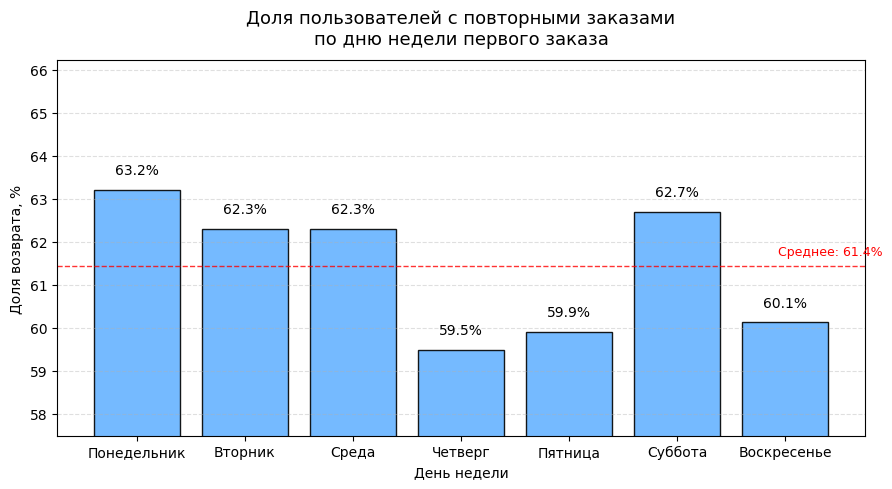

In [ ]:
# === 4.3.1. Доля пользователей с повторными заказами по дню недели первого заказа ===
import matplotlib.pyplot as plt


weekday_plot = seg_weekday.copy()

x = weekday_plot['first_weekday']
y = weekday_plot['retention_share']

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(x, y,
              color='#66b3ff',
              edgecolor='black',
              alpha=0.9)

# средняя доля возврата по всем дням
avg_retention = y.mean()

# горизонтальная линия среднего
ax.axhline(avg_retention,
           color='red',
           linestyle='--',
           linewidth=1,
           alpha=0.8)

ax.text(len(x) - 0.1,
        avg_retention + 0.2,
        f'Среднее: {avg_retention:.1f}%',
        color='red',
        fontsize=9,
        ha='right',
        va='bottom')

# подписи над столбцами
for bar, val in zip(bars, y):
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.3,
            f'{val:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10)

ax.set_title('Доля пользователей с повторными заказами\nпо дню недели первого заказа',
             fontsize=13, pad=12)
ax.set_xlabel('День недели')
ax.set_ylabel('Доля возврата, %')


y_min = y.min() - 2
y_max = y.max() + 3
ax.set_ylim(y_min, y_max)

ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Выводы по дню недели первого заказа

**Общая картина.**  
Разброс долей возврата между днями недели оказался умеренным — от **59.5% (четверг)** до **63.2% (понедельник)**.  
То есть разница между самым «сильным» и самым «слабым» днём составляет около **3.5 п.п.**, что довольно немного для продуктовой метрики.

**Что заметно:**
- **Понедельник, вторник, среда и суббота** находятся *ненамного выше среднего уровня* (≈61.8%), но преимущество небольшое.
- **Четверг и пятница** чуть отстают, но также без существенного разрыва.
- **Воскресенье** близко к среднему и выглядит нейтральным.

**Вывод.**  
Существенной зависимости между днём недели первого заказа и вероятностью возврата **не наблюдается**.  
Отдельные колебания есть, но они выглядят естественными и не формируют устойчивого паттерна, на который можно было бы опереться в принятии решений.


---

**Задача 4.3.2.** Изучения влияния среднего интервала  между заказами на удержание клиентов.

- Рассчет среднего времени между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Изучение, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [56]:
# === 4.3.2. Подготовка групп и расчёт среднего интервала между заказами ===

# Срезы пользователей по числу заказов
group_2_4 = user_profile_trimmed.query('2 <= total_orders <= 4')
group_5_plus = user_profile_trimmed.query('total_orders >= 5')

# Подсчёт средних интервалов между заказами
mean_2_4 = group_2_4['avg_days_between_orders'].mean()
mean_5_plus = group_5_plus['avg_days_between_orders'].mean()

print("Количество пользователей (2–4 заказа):", len(group_2_4))
print("Количество пользователей (5+ заказов):", len(group_5_plus))

print(f"\nСредний интервал между заказами (2–4 заказа): {mean_2_4:.2f} дней")
print(f"Средний интервал между заказами (5+ заказов): {mean_5_plus:.2f} дней")

Количество пользователей (2–4 заказа): 7159
Количество пользователей (5+ заказов): 6181

Средний интервал между заказами (2–4 заказа): 21.33 дней
Средний интервал между заказами (5+ заказов): 9.96 дней


In [57]:
# === 4.3.2. Описательная статистика среднего интервала между заказами ===

cols = ['mean', '50%', 'std', 'min', 'max']

for name, df in [('2–4 заказа', group_2_4), ('5+ заказов', group_5_plus)]:
    print(f'\n{name}')
    desc = df['avg_days_between_orders'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
    display(desc)


2–4 заказа


count    7159.000000
mean       21.326326
std        28.589919
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
90%        59.600000
95%        84.100000
max       148.000000
Name: avg_days_between_orders, dtype: float64


5+ заказов


count    6181.000000
mean        9.961303
std         7.842622
min         0.000000
25%         3.916667
50%         8.200000
75%        14.200000
90%        21.333333
95%        26.000000
max        37.500000
Name: avg_days_between_orders, dtype: float64

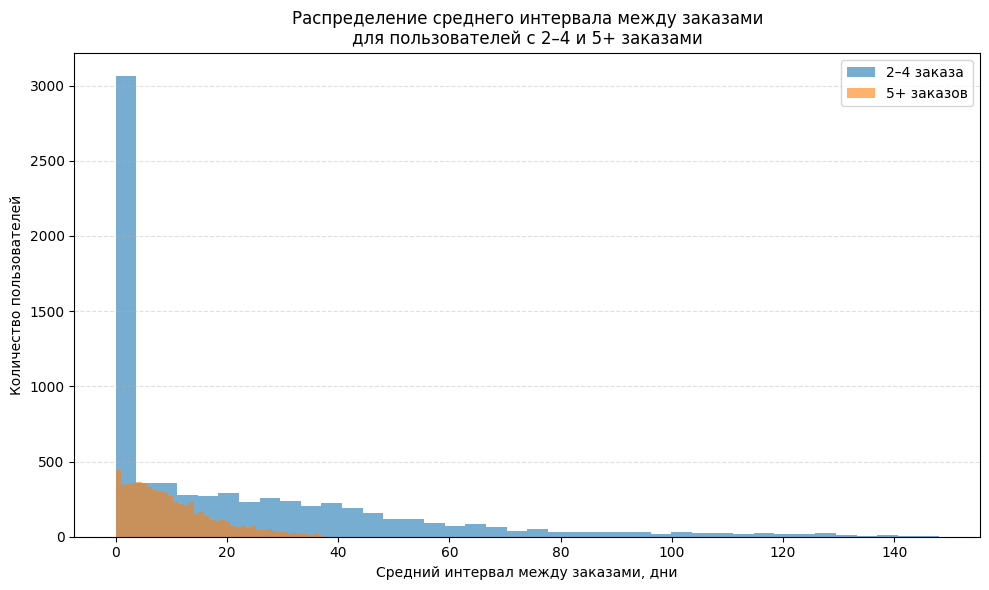

In [58]:
import matplotlib.pyplot as plt

# общее количество корзин одно и то же, чтобы формы были сопоставимы
bins = 40  

plt.figure(figsize=(10, 6))

plt.hist(
    group_2_4['avg_days_between_orders'],
    bins=bins,
    alpha=0.6,
    label='2–4 заказа'
)

plt.hist(
    group_5_plus['avg_days_between_orders'],
    bins=bins,
    alpha=0.6,
    label='5+ заказов'
)

plt.xlabel('Средний интервал между заказами, дни')
plt.ylabel('Количество пользователей')
plt.title('Распределение среднего интервала между заказами\nдля пользователей с 2–4 и 5+ заказами')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Вывод: как средний интервал между заказами влияет на возврат пользователей

Анализ двух групп пользователей — **2–4 заказа** и **5+ заказов** — показывает заметное различие в среднем интервале между их покупками:

- **Средний интервал (2–4 заказа): 21.33 дня**  
- **Средний интервал (5+ заказов): 9.96 дня**

То есть пользователи, совершающие **5 и более заказов**, делают новые покупки **в два раза быстрее**.

Однако, чтобы понять, насколько устойчиво это различие, дополнительно изучено *распределения интервалов*.  
Результаты показывают, что:

- У группы **5+ заказов** распределение плотнее, большая часть интервалов находится в зоне **5–15 дней**,  
  хвосты короткие, выбросов почти нет.
- У группы **2–4 заказов** вариативность существенно выше:  
  медиана — 0 дней, но хвосты уходят до **80–140 дней**, что говорит о менее регулярном поведении.

ИТОГИ

Обе части анализа хорошо согласуются друг с другом:

- **Пользователи, делающие заказы чаще, действительно возвращаются быстрее.**  
  Это видно и по среднему интервалу, и по форме распределений.
- **Редкие покупатели менее стабильны**: у них много пауз, разнообразие интервалов велико,  
  а длинные хвосты свидетельствуют о нерегулярности поведения.

Таким образом, **короткие интервалы между покупками — один из признаков лояльности**:  
пользователи, которые чаще возвращаются в сервис, демонстрируют более предсказуемую и плотную динамику заказов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучение, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. 
---

**Задача 4.4.1:** Проведение корреляционного анализ:
- Рассчет коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). 

- Анализ полученных результатов. Если полученные значения будут близки к нулю, проверка разброса данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`. Выделение сегментов:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализизация результатов корреляции с помощью тепловой карты.
- Изучение вопроса: какие признаки наиболее связаны с количеством заказов?

---

In [59]:
import phik
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt

In [ ]:
# === 4.4.1. Корреляция phi_k для общего набора пользователей ===


import phik
from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Выбираем признаки для анализа
cols_for_corr = [
    'total_orders',          # целевая переменная — число заказов
    'avg_revenue_rub',       # средняя выручка с заказа
    'avg_tickets_count',     # среднее число билетов в заказе
    'avg_days_between_orders',  # средний интервал между заказами
    'first_device',          # устройство первого заказа
    'first_region',          # регион первого заказа
    'first_service',         # билетный оператор первого заказа
    'first_event_type',      # жанр первого мероприятия
    'first_weekday_num',     # номер дня недели первого заказа (1–7)
]

corr_df = user_profile_trimmed[cols_for_corr].copy()

# 2. Указываем числовые (интервальные) признаки
interval_cols = [
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_weekday_num',
]

# 3. Считаем матрицу корреляции phi_k
phik_matrix = corr_df.phik_matrix(interval_cols=interval_cols)

# 4. Смотрим матрицу в табличном виде
display(phik_matrix.round(3))

,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,first_device,first_region,first_service,first_event_type,first_weekday_num
total_orders,1.000,0.000,0.252,0.285,0.027,0.117,0.025,0.025,0.060
avg_revenue_rub,0.000,1.000,0.519,0.000,0.021,0.000,0.203,0.092,0.014
avg_tickets_count,0.252,0.519,1.000,0.084,0.058,0.109,0.153,0.082,0.009
avg_days_between_orders,0.285,0.000,0.084,1.000,0.018,0.081,0.053,0.051,0.000
first_device,0.027,0.021,0.058,0.018,1.000,0.116,0.084,0.062,0.073
first_region,0.117,0.000,0.109,0.081,0.116,1.000,0.696,0.508,0.155
first_service,0.025,0.203,0.153,0.053,0.084,0.696,1.000,0.587,0.064
first_event_type,0.025,0.092,0.082,0.051,0.062,0.508,0.587,1.000,0.083
first_weekday_num,0.060,0.014,0.009,0.000,0.073,0.155,0.064,0.083,1.000


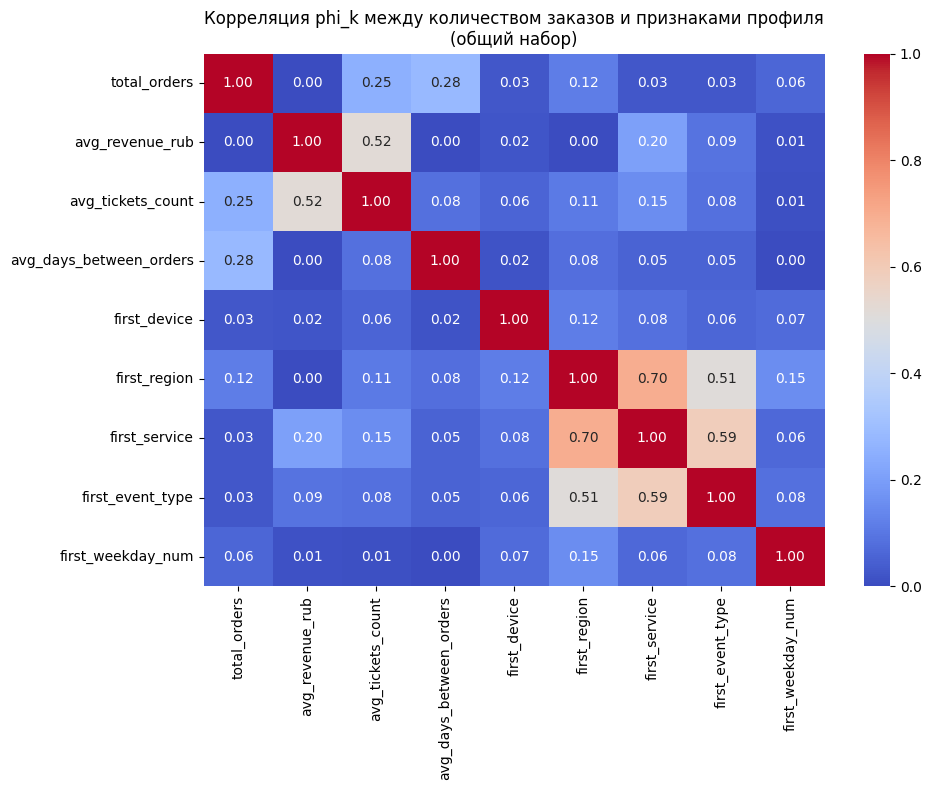

In [61]:
# === Тепловая карта phi_k для общего набора ===

plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=0,
    vmax=1
)

plt.title('Корреляция phi_k между количеством заказов и признаками профиля\n(общий набор)')
plt.tight_layout()
plt.show()

In [62]:
# === 4.4.1b. Сегменты по числу заказов и phi_k для них ===

def segment_orders(n):
    """Категоризация пользователей по числу заказов."""
    if n == 1:
        return '1 заказ'
    elif 2 <= n <= 4:
        return '2–4 заказа'
    else:
        return '5+ заказов'

# Добавляем сегмент в профайл пользователей
user_profile_trimmed['orders_segment'] = user_profile_trimmed['total_orders'].apply(segment_orders)

# Проверим распределение сегментов (чисто для контроля)
print(user_profile_trimmed['orders_segment'].value_counts())

# Признаки для корреляции с сегментом заказов
cols_for_corr_seg = [
    'orders_segment',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type',
    'first_weekday_num',
]

corr_seg_df = user_profile_trimmed[cols_for_corr_seg].copy()

# Числовые признаки внутри этого набора
interval_cols_seg = [
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_weekday_num',
]

# Матрица phi_k по всем признакам + сегменту
phik_seg = corr_seg_df.phik_matrix(interval_cols=interval_cols_seg)

# Оставляем только корреляции с orders_segment
orders_corr = (
    phik_seg[['orders_segment']]
    .drop(index='orders_segment')
    .sort_values('orders_segment', ascending=False)
)

display(orders_corr.round(3))

orders_segment
1 заказ       8374
2–4 заказа    7159
5+ заказов    6181
Name: count, dtype: int64


,orders_segment
avg_days_between_orders,0.466
avg_tickets_count,0.405
first_region,0.124
avg_revenue_rub,0.080
first_service,0.077
first_event_type,0.041
first_weekday_num,0.035
first_device,0.017


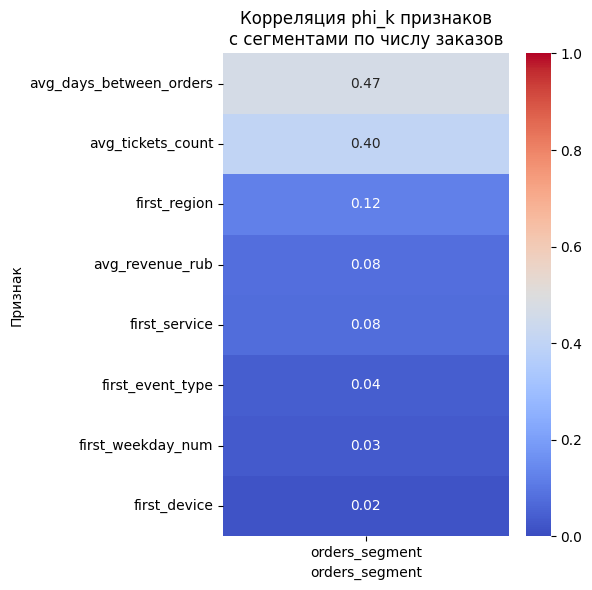

In [63]:
# === Тепловая карта phi_k: признаки vs сегменты по числу заказов ===

plt.figure(figsize=(6, 6))
sns.heatmap(
    orders_corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=0,
    vmax=1
)

plt.title('Корреляция phi_k признаков\nс сегментами по числу заказов')
plt.ylabel('Признак')
plt.xlabel('orders_segment')
plt.tight_layout()
plt.show()

Выводы по корреляционному анализу (phi_k)

Связь признаков профиля с общим количеством заказов

Матрица корреляций phi_k для полного набора пользователей показывает:

- **Сильных связей с числом заказов нет** — коэффициенты низкие.
- Наиболее заметные связи наблюдаются у поведенческих признаков:
  - `avg_tickets_count` — *phi_k ≈ 0.25*
  - `avg_days_between_orders` — *phi_k ≈ 0.28*

Это означает, что пользователи, которые:
- покупают в заказе больше билетов;
- совершают покупки более регулярно,

слегка чаще относятся к группе более «возвращаемых» пользователей.

Атрибуты первого заказа (тип устройства, регион, оператор, жанр события, день недели) практически **не связаны** с количеством покупок.

---

Корреляции после сегментации пользователей по числу заказов

Сегментация на группы:
- **1 заказ**
- **2–4 заказа**
- **5+ заказов**

позволила корректнее оценить влияние признаков, не искажённое доминированием группы с 1 заказом.

После сегментации наиболее заметные зависимости:

- **`avg_days_between_orders` — 0.47**  
  Наиболее сильный предиктор: чем меньше интервал между покупками, тем выше вовлечённость пользователя.

- **`avg_tickets_count` — 0.40**  
  Пользователи, покупающие больше билетов, заметно чаще совершают повторные покупки.

- **`first_region` — 0.12**  
  Слабый региональный эффект.

- **`avg_revenue_rub` и `first_service` — около 0.08**  
  Незначимое, но отмечаемое влияние.

Остальные признаки (`first_event_type`, `first_device`, `first_weekday_num`) демонстрируют минимальную связь с числом заказов.

---

Главные выводы

**1. Поведенческие признаки — ключевые факторы возврата.**  
Регулярность покупок (`avg_days_between_orders`) и среднее количество билетов (`avg_tickets_count`) лучше всего объясняют количество заказов.

**2. Атрибуты первого заказа почти не влияют на дальнейшее поведение.**  
Жанр события, устройство, регион, день недели и оператор первого заказа имеют крайне слабую связь с числом будущих покупок.


### 5. Общий вывод и рекомендации



Итоговые выводы и рекомендации

**1. Подготовка и качество данных**

В анализ включены данные заказов пользователей сервиса «Яндекс Афиша» за период **июнь–октябрь 2024 года**.  
Перед исследованием выполнены основные этапы подготовки:

- проведена проверка и корректировка типов данных;
- выручка, представленная в рублях и тенге, приведена к единой валюте — **рублю**;
- отрицательные значения выручки интерпретированы как возвраты и сохранены;
- выбросы по числу заказов и выручке проанализированы; сверх **99-го перцентиля** значения по числу заказов исключены из итоговых расчётов как нерепрезентативные.

Данные подготовлены корректно и позволяют анализировать поведение пользователей.

---

**2. Описание выборки и ключевые статистики**

В итоговый датасет вошли **21 700+ пользователей**.

Распределение по числу заказов:

- **1 заказ — 48%**  
- **2–4 заказа — 41%**  
- **5+ заказов — 11%**

Структура показывает, что почти половина пользователей совершают единичную покупку, однако значимая доля возвращается, а сегмент 5+ заказов формирует устойчивую и вовлечённую аудиторию.

---

**3. Факторы, связанные с возвратом пользователей**

**3.1. Признаки первого заказа**

Влияние «точки входа» умеренное:

- различия по жанрам — небольшие,
- первый заказ чаще совершается через мобильные устройства, однако
уровень возврата у мобильных и десктопных пользователей отличается незначительно,
поэтому тип устройства не является фактором удержания,
- региональные различия не формируют выраженных паттернов,
- среди билетных операторов нет устойчивых лидеров по удержанию.

**Точка входа отражает стиль поведения, но не является сильным фактором возвратов.**

---

**3.2. Средняя выручка с заказа**

- пользователи с 1 заказом чаще всего имеют среднюю выручку **до 400–600 руб.**;
- пользователи с повторными заказами имеют немного выше среднюю выручку;
- различия умеренные.

**Средняя выручка не является ключевым драйвером удержания.**

---

**3.3. Среднее число билетов**

- основная масса — **1–2 билета**;
- сегменты **2–3** и **3–5** билетов показывают более высокую долю возвратов;
- при **5+ билетах** данных мало, доли нестабильны.

**Покупка большего числа билетов может указывать на семейные/групповые посещения, что потенциально повышает лояльность, но зависимость умеренная.**

---

**3.4. Временные характеристики**

- влияние дня недели минимально;
- самый яркий поведенческий признак — **интервал между покупками**:
  - у пользователей 5+ заказов — ~**10 дней**,
  - у пользователей 2–4 заказов — ~**21 день**.

При этом интервал — **не причина**, а **следствие** высокой вовлечённости.

---

**3.5. Корреляционный анализ**

Phi-K показал:

- заметная связь — между числом заказов и **интервалом** между покупками;
- умеренная — с **числом билетов**;
- слабые — с регионом, жанром, оператором.

**Сильных причинных факторов вне поведенческих характеристик не выявлено.**

---

**4. Общий вывод**

Основной фактор, определяющий возврат пользователя, — **его вовлечённость**, проявляющаяся в частоте посещений.  
Характеристики первого заказа (жанр, сервис, устройство, регион) показывают умеренное влияние.  
Наибольший потенциал роста — **в работе с пользователями, совершившими 2–4 заказа**, а также с группами и семьями.

---

**5. Рекомендации**

**5.1. Усилить retention-механику для активных пользователей для поддержания и закрепления лояльности**
Группа пользователей с регулярными покупками и которкими интервалами является хорошим кандидатом для персональных предложений, их поведение демонстрирует высокий уровень вовлеченности, которую целесообразно поддерживать.

Рекомендуется:
- персональные рекомендации,
- приоритетный доступ к событиям,
- гибкая программа лояльности,
- подборки по любимым жанрам.

---

**5.2. Использовать активных пользователей как драйверов привлечения**

Сегмент, покупающий **4+ билетов**, особенно ценен:

- это семьи и компании друзей,
- они могут приводить новых клиентов.

Эффективны:
- скидки за группы,
- акции «приведи друга»,
- промокоды,
- специальные семейные предложения.

---

**5.3. Развивать “средний сегмент” — 2–4 заказа**

Это наиболее массовая группа потенциальных повторных клиентов.
Целесообразно работать с сегментом 2–4 заказов как с аудиторией “формирующейся привычки”: усиливать регулярные касания, давать персональные рекомендации, выделять релевантные события по их интересам и городу. Главная цель — превращение спорадических походов в регулярные

Рекомендуется:
- персональные подборки на основе истории покупок,
- подборки по жанрам и форматам,
- рекомендации по событиям в их городе,
- рекомендации похожих мероприятий, особенно для сегмента семейных посещений (3–4 билета),
- предложения по любимым площадкам или артистам

---

**5.4. Следить за динамикой жанров и сезонностью**

Тип первого события оказывает слабое влияние, но сезонная динамика может менять структуру спроса.  
Рекомендуется анализировать более длинный период.

---

**5.5. Расширять аналитику поведения**

Перспективные направления:
- когортный анализ по событиям и площадкам,
- исследование серийности посещений,
- связь поведения с расстоянием до площадки,
- анализ топ-мероприятий и их влияния на удержание.